# WISJ Summer School: Tabular ML Workshop
## Module 1: E-commerce Dataset Generation

**Instructor**: Marco Visentini-Scarzanella, Sr. Manager Applied Science, Amazon Japan

---

### **E-commerce Product Success Prediction**

In this workshop, we'll predict the **success score (0-100)** of products on an e-commerce platform. This is a regression problem where we analyze how various product and seller characteristics influence product performance.

**Learning Objectives:**
1. Understand how to explore datasets
2. See the impact of feature correlations and data quality issues
3. Prepare for the complete ML pipeline (preprocessing → modeling → evaluation)

---

###**Dataset Features Overview**

**Numerical Features:**
- `price`: Product price ($10-$500, log-normal distribution)
- `seller_rating`: Seller rating (1-5, normal distribution)
- `product_weight`: Product weight (0.1-20kg, log-normal)
- `days_since_launch`: Days since product launch (1-365)
- `description_length`: Description length (100-2000 characters)

**Categorical Features:**
- `category`: Electronics, Clothing, Home, Sports, Books
- `shipping_method`: Standard, Express, Overnight
- `seller_type`: Individual, Business, Premium

**Ordinal/Binary Features:**
- `product_condition`: 1-4 (Fair to New)
- `seller_experience`: 1-3 (Beginner to Expert)
- `has_reviews`: 0/1 (Boolean)
- `international_shipping`: 0/1 (Boolean)

**Target Variable:**
- `success_score`: Product success score (0-100, continuous)

---

In [ ]:
# CONFIGURATION (Adjustable for different class sizes)
DATASET_SIZE = 500        # Options: 500, 1000, 2000 (adjust based on class needs)
RANDOM_SEED = 42           # For reproducible results across all students
INCLUDE_DATA_ISSUES = True # Add realistic missing values & outliers

# Module 1: Data generation
## (Run once and then collapse)

In [ ]:
# @title
# ===================================================================
# WISJ Summer School: Tabular ML Workshop - Module 1
# E-commerce Dataset Generation
# ===================================================================

# IMPORTS
import numpy as np
import pandas as pd
from scipy import stats
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import IsolationForest
from scipy import stats
import warnings
import time
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor

# Optional libraries
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("XGBoost available")
except ImportError:
    XGBOOST_AVAILABLE = False
    from sklearn.ensemble import RandomForestRegressor
    print("Using RandomForest instead of XGBoost")

try:
    import shap
    SHAP_AVAILABLE = True
    print("SHAP available")
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not available")


# Set plotting style for inline display
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully! Ready to generate data.")
print("=" * 60)



print(f"Configuration:")
print(f"Dataset Size: {DATASET_SIZE:,} samples")
print(f"Random Seed: {RANDOM_SEED} (for reproducibility)")
print(f"Data Issues: {'Included' if INCLUDE_DATA_ISSUES else 'Clean dataset'}")
print("=" * 60)


# HELPER FUNCTIONS

def generate_correlated_numerical_features(n_samples, random_state):
    """Generate 5 correlated numerical features using multivariate normal distribution."""
    np.random.seed(random_state)

    # Define realistic correlation matrix based on e-commerce domain knowledge
    corr_matrix = np.array([
        #       price  rating  weight  days  desc_len
        [1.00, -0.15,   0.25,  0.10,   0.20],  # price: neg with rating, pos with weight/desc
        [-0.15, 1.00,  -0.05,  0.40,   0.30],  # rating: pos with time/desc (experienced sellers)
        [0.25, -0.05,   1.00,  0.05,   0.15],  # weight: pos with price/desc
        [0.10,  0.40,   0.05,  1.00,   0.35],  # days: pos with rating/desc (established products)
        [0.20,  0.30,   0.15,  0.35,   1.00]   # desc_len: pos with all (effort correlates)
    ])

    # Generate multivariate normal samples
    mvn_samples = np.random.multivariate_normal(
        mean=np.zeros(5), cov=corr_matrix, size=n_samples
    )

    # Transform to desired distributions
    price = np.exp(mvn_samples[:, 0] * 0.6 + 3.8)
    seller_rating = np.clip(mvn_samples[:, 1] * 0.7 + 4.0, 1.0, 5.0)
    product_weight = np.exp(mvn_samples[:, 2] * 0.8 + 0.5)
    days_since_launch = np.clip((mvn_samples[:, 3] + 2) * 60, 1, 365).astype(int)
    description_length = np.clip(mvn_samples[:, 4] * 200 + 800, 100, 2000).astype(int)

    return price, seller_rating, product_weight, days_since_launch, description_length


def generate_target_simple(df):
    """Generate target variable (success_score) using realistic business relationships."""
    # Normalize numerical features to [0,1] for consistent weighting
    norm_rating = (df['seller_rating'] - 1) / 4  # 1-5 → 0-1
    norm_time = np.log(df['days_since_launch'] + 1) / np.log(366)  # Log normalize time
    norm_price_inv = 1 / (1 + df['price'] / 100)  # Inverse relationship, bounded

    # Category effects (some categories naturally perform better)
    category_effects = {
        'Electronics': 15, 'Clothing': 10, 'Home': 12, 'Sports': 8, 'Books': 5
    }
    category_score = df['category'].map(category_effects)

    # Other feature effects
    condition_score = df['product_condition'] * 2.5  # 1→2.5, 4→10
    reviews_score = df['has_reviews'] * 10  # Reviews provide social proof

    shipping_effects = {'Standard': 0, 'Express': 3, 'Overnight': 5}
    shipping_score = df['shipping_method'].map(shipping_effects)

    seller_type_effects = {'Individual': 0, 'Business': 5, 'Premium': 10}
    seller_type_score = df['seller_type'].map(seller_type_effects)

    # Linear combination of all effects (business-driven weights)
    base_score = (
        30 * norm_rating +           # Main predictor (30 points max)
        20 * norm_time +             # Time matters, logarithmic (20 points max)
        category_score +             # Category bias (5-15 points)
        condition_score +            # Condition effect (2.5-10 points)
        reviews_score +              # Reviews effect (0 or 10 points)
        10 * norm_price_inv +        # Price effect, inverse (up to 10 points)
        shipping_score +             # Shipping effect (0-5 points)
        seller_type_score            # Seller type effect (0-10 points)
    )

    # Add controlled noise (±8 points standard deviation)
    np.random.seed(42)  # Fixed seed for reproducible noise
    noise = np.random.normal(0, 8, len(df))

    # Final score, clipped to [0, 100]
    success_score = np.clip(base_score + noise, 0, 100)

    return success_score


def inject_data_problems(df):
    """Add realistic data quality issues to simulate real-world challenges."""
    df_dirty = df.copy()
    n_samples = len(df_dirty)

    # Set seed for reproducible problems
    np.random.seed(123)

    # MISSING VALUES WITH REALISTIC PATTERNS

    # 1. New/inexperienced sellers often missing ratings
    mask_new_sellers = df_dirty['seller_experience'] == 1
    missing_rating_prob = np.where(mask_new_sellers, 0.3, 0.05)
    missing_rating_mask = np.random.random(n_samples) < missing_rating_prob
    df_dirty.loc[missing_rating_mask, 'seller_rating'] = np.nan

    # 2. Books and digital products often missing weight
    mask_books = df_dirty['category'] == 'Books'
    missing_weight_prob = np.where(mask_books, 0.4, 0.08)
    missing_weight_mask = np.random.random(n_samples) < missing_weight_prob
    df_dirty.loc[missing_weight_mask, 'product_weight'] = np.nan

    # 3. Random missing description lengths (lazy sellers)
    missing_desc_mask = np.random.random(n_samples) < 0.1
    df_dirty.loc[missing_desc_mask, 'description_length'] = np.nan

    # 4. Some missing launch dates (data collection issues)
    missing_days_mask = np.random.random(n_samples) < 0.05
    df_dirty.loc[missing_days_mask, 'days_since_launch'] = np.nan

    # OUTLIERS (affect ~5% of data)
    n_outliers = int(0.05 * n_samples)
    outlier_indices = np.random.choice(n_samples, n_outliers, replace=False)

    # Price outliers: luxury/premium items with extreme prices
    price_outlier_indices = outlier_indices[:n_outliers//2]
    df_dirty.loc[price_outlier_indices, 'price'] *= np.random.uniform(5, 15, len(price_outlier_indices))

    # Rating outliers: fake perfect ratings
    rating_outlier_indices = outlier_indices[n_outliers//2:]
    df_dirty.loc[rating_outlier_indices, 'seller_rating'] = 5.0

    # Weight outliers: extremely light items (digital products coded wrong)
    weight_outlier_count = max(1, n_outliers//4)
    weight_outlier_indices = np.random.choice(outlier_indices, weight_outlier_count, replace=False)
    df_dirty.loc[weight_outlier_indices, 'product_weight'] = np.random.uniform(0.001, 0.01, weight_outlier_count)

    return df_dirty


def generate_ecommerce_dataset(n_samples=1000, random_state=42, include_issues=True):
    """MAIN FUNCTION: Generate the complete e-commerce dataset."""
    np.random.seed(random_state)

    # Generate correlated numerical features
    price, seller_rating, product_weight, days_since_launch, description_length = \
        generate_correlated_numerical_features(n_samples, random_state)

    # Generate independent categorical features
    categories = ['Electronics', 'Clothing', 'Home', 'Sports', 'Books']
    category = np.random.choice(categories, n_samples, p=[0.3, 0.25, 0.2, 0.15, 0.1])

    shipping_methods = ['Standard', 'Express', 'Overnight']
    shipping_method = np.random.choice(shipping_methods, n_samples, p=[0.6, 0.3, 0.1])

    seller_types = ['Individual', 'Business', 'Premium']
    seller_type = np.random.choice(seller_types, n_samples, p=[0.4, 0.5, 0.1])

    # Generate independent ordinal and binary features
    product_condition = np.random.choice([1, 2, 3, 4], n_samples, p=[0.1, 0.2, 0.3, 0.4])
    seller_experience = np.random.choice([1, 2, 3], n_samples, p=[0.3, 0.5, 0.2])
    has_reviews = np.random.choice([0, 1], n_samples, p=[0.3, 0.7])
    international_shipping = np.random.choice([0, 1], n_samples, p=[0.6, 0.4])

    # Generate noise features (irrelevant for prediction - educational purpose)
    listing_id = [f"ITEM_{i:06d}" for i in range(n_samples)]
    seller_location_code = np.random.randint(10000, 99999, n_samples)

    # Create clean DataFrame
    df = pd.DataFrame({
        'listing_id': listing_id,
        'price': price,
        'seller_rating': seller_rating,
        'product_weight': product_weight,
        'days_since_launch': days_since_launch,
        'description_length': description_length,
        'category': category,
        'shipping_method': shipping_method,
        'seller_type': seller_type,
        'product_condition': product_condition,
        'seller_experience': seller_experience,
        'has_reviews': has_reviews,
        'international_shipping': international_shipping,
        'seller_location_code': seller_location_code
    })

    # Generate target variable
    df['success_score'] = generate_target_simple(df)

    # Add data quality issues if requested
    if include_issues:
        df = inject_data_problems(df)

    return df


def print_dataset_summary(df):
    """Print a comprehensive summary of the generated dataset."""
    print("=" * 70)
    print("E-COMMERCE DATASET SUMMARY")
    print("=" * 70)

    print(f"\nDataset Structure:")
    print(f"   Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"   Memory usage: ~{df.memory_usage(deep=True).sum() / 1024:.1f} KB")

    print(f"\nTarget Variable (success_score):")
    print(f"   Mean: {df['success_score'].mean():.2f}")
    print(f"   Std:  {df['success_score'].std():.2f}")
    print(f"   Range: {df['success_score'].min():.1f} - {df['success_score'].max():.1f}")

    print(f"\nMissing Values Analysis:")
    missing_counts = df.isnull().sum()
    missing_features = missing_counts[missing_counts > 0]
    if len(missing_features) > 0:
        print(f"   Total missing values: {missing_counts.sum():,}")
        for feature, count in missing_features.items():
            pct = (count / len(df)) * 100
            print(f"   {feature}: {count:,} ({pct:.1f}%)")
    else:
        print("No missing values detected")

    print(f"\nFeature Types Breakdown:")
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()
    # Remove target from numerical count
    if 'success_score' in numerical_features:
        numerical_features.remove('success_score')
    print(f"Numerical: {len(numerical_features)} features")
    print(f"Categorical: {len(categorical_features)} features")
    print(f"Target: 1 feature (success_score)")

    print(f"\nFeature Correlations (Top 5 Numerical):")
    numerical_cols = ['price', 'seller_rating', 'product_weight', 'days_since_launch', 'description_length']
    corr_matrix = df[numerical_cols].corr()
    print("   Correlation Matrix:")
    print(corr_matrix.round(3).to_string())

    print(f"\nCategory Distribution:")
    category_dist = df['category'].value_counts()
    for cat, count in category_dist.items():
        pct = (count / len(df)) * 100
        print(f"   {cat}: {count:,} ({pct:.1f}%)")



    print("=" * 70)


# ===================================================================
# DATASET GENERATION & ANALYSIS
# ===================================================================

print("\nGenerating E-commerce Dataset...")
print(f"Creating {DATASET_SIZE:,} product records with realistic relationships...")

# Generate the dataset
dataset = generate_ecommerce_dataset(
    n_samples=DATASET_SIZE,
    random_state=RANDOM_SEED,
    include_issues=INCLUDE_DATA_ISSUES
)

print(f"Dataset generation complete!")
print(f"Generated {dataset.shape[0]:,} products with {dataset.shape[1]} features")

# Print comprehensive analysis
print_dataset_summary(dataset)

# Display sample data
print("\nSample Data (First 5 rows):")
print("=" * 70)
display(dataset.head())

# Final status
print("\n" + "=" * 70)
print("MODULE 1 COMPLETE!")
print("=" * 70)
print(f"Dataset ready: {dataset.shape[0]:,} products × {dataset.shape[1]} features")
print(f"Variable name: 'dataset' (use this in Module 2)")
print(f"Target variable: 'success_score' (continuous values 0-100)")

XGBoost available
SHAP available
Libraries imported successfully! Ready to generate data.
Configuration:
Dataset Size: 500 samples
Random Seed: 42 (for reproducibility)
Data Issues: Included

Generating E-commerce Dataset...
Creating 500 product records with realistic relationships...
Dataset generation complete!
Generated 500 products with 15 features
E-COMMERCE DATASET SUMMARY

Dataset Structure:
   Shape: 500 rows × 15 columns
   Memory usage: ~171.5 KB

Target Variable (success_score):
   Mean: 74.78
   Std:  12.27
   Range: 37.7 - 100.0

Missing Values Analysis:
   Total missing values: 199
   seller_rating: 60 (12.0%)
   product_weight: 51 (10.2%)
   days_since_launch: 21 (4.2%)
   description_length: 67 (13.4%)

Feature Types Breakdown:
Numerical: 10 features
Categorical: 4 features
Target: 1 feature (success_score)

Feature Correlations (Top 5 Numerical):
   Correlation Matrix:
                    price  seller_rating  product_weight  days_since_launch  description_length
price

,listing_id,price,seller_rating,product_weight,days_since_launch,description_length,category,shipping_method,seller_type,product_condition,seller_experience,has_reviews,international_shipping,seller_location_code,success_score
0,ITEM_000000,51.152739,3.671683,1.072647,152.0,NaN,Sports,Express,Individual,4,2,1,0,39377,78.671882
1,ITEM_000001,126.506715,3.613594,2.548122,96.0,928.0,Home,Standard,Individual,4,3,0,0,59573,60.411299
2,ITEM_000002,25.315270,3.702013,1.115273,127.0,1159.0,Electronics,Express,Business,2,2,0,0,52733,77.866700
3,ITEM_000003,23.742572,4.063232,0.865278,160.0,1030.0,Electronics,Standard,Business,2,3,1,0,21760,95.457184
4,ITEM_000004,361.450514,3.179285,0.962188,24.0,765.0,Clothing,Express,Business,4,1,1,0,35762,71.317288



MODULE 1 COMPLETE!
Dataset ready: 500 products × 15 features
Variable name: 'dataset' (use this in Module 2)
Target variable: 'success_score' (continuous values 0-100)


## Module 2: Data Preprocessing & Visualization
### Cell 1: Setup & Helper Functions
### Instructions

**Run this cell once, then collapse it to keep your notebook clean.**

This cell contains:
- All necessary imports
- Helper functions for visualizations
- EDA dashboard function
- Configuration for inline plotting

**Prerequisites**: This module expects the `dataset` variable from Module 1 to be available.

In [ ]:
#@title Setup & Helper Functions (Run Once, Then Collapse)

# ==========================================
# COMPREHENSIVE EDA DASHBOARD FUNCTION
# ==========================================

def create_eda_dashboard(df):
    """Create comprehensive EDA dashboard with 9 panels."""
    fig = plt.figure(figsize=(18, 12))

    # 1. Missing values heatmap
    plt.subplot(3, 3, 1)
    sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='RdYlBu_r')
    plt.title('Missing Values Heatmap', fontweight='bold')

    # 2. Missing values by feature
    plt.subplot(3, 3, 2)
    missing_counts = df.isnull().sum()
    missing_features = missing_counts[missing_counts > 0]
    if len(missing_features) > 0:
        missing_pct = (missing_features / len(df)) * 100
        bars = plt.bar(range(len(missing_features)), missing_pct.values, color='coral')
        plt.xticks(range(len(missing_features)),
                  [col.replace('_', '\n') for col in missing_features.index],
                  rotation=0, fontsize=9)
        plt.ylabel('Missing %')
        plt.title('Missing Values by Feature', fontweight='bold')
        # Add percentage labels on bars
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.2,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=8)
    else:
        plt.text(0.5, 0.5, 'No Missing Values', ha='center', va='center',
                transform=plt.gca().transAxes, fontsize=12)
        plt.title('Missing Values by Feature', fontweight='bold')

    # 3. Feature correlations
    plt.subplot(3, 3, 3)
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'success_score' in numerical_cols:
        numerical_cols.remove('success_score')
    if len(numerical_cols) > 1:
        corr_matrix = df[numerical_cols].corr()
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                    square=True, linewidths=0.5, fmt='.2f', cbar_kws={'shrink': 0.8})
    plt.title('Feature Correlations', fontweight='bold')

    # 4. Target distribution
    plt.subplot(3, 3, 4)
    if 'success_score' in df.columns:
        plt.hist(df['success_score'].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(df['success_score'].mean(), color='red', linestyle='--',
                    label=f'Mean: {df["success_score"].mean():.1f}')
        plt.xlabel('Success Score')
        plt.ylabel('Frequency')
        plt.title('Target Distribution', fontweight='bold')
        plt.legend()

    # 5. Price distribution
    plt.subplot(3, 3, 5)
    if 'price' in df.columns:
        plt.hist(df['price'].dropna(), bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
        plt.axvline(df['price'].mean(), color='red', linestyle='--', alpha=0.7)
        plt.title('Price Distribution', fontweight='bold')
        plt.xlabel('Price ($)')
        plt.ylabel('Frequency')

    # 6. Category analysis
    plt.subplot(3, 3, 6)
    if 'category' in df.columns:
        df['category'].value_counts().plot(kind='bar', color='orange', alpha=0.7)
        plt.title('Category Distribution', fontweight='bold')
        plt.xlabel('Category')
        plt.ylabel('Count')
        plt.xticks(rotation=45)

    # 7. Seller rating vs success scatter
    plt.subplot(3, 3, 7)
    if 'seller_rating' in df.columns and 'success_score' in df.columns:
        clean_data = df[['seller_rating', 'success_score']].dropna()
        plt.scatter(clean_data['seller_rating'], clean_data['success_score'],
                   alpha=0.6, s=20, color='purple')
        plt.xlabel('Seller Rating')
        plt.ylabel('Success Score')
        plt.title('Rating vs Success', fontweight='bold')
        # Add trend line if we have enough data
        if len(clean_data) > 1:
            z = np.polyfit(clean_data['seller_rating'], clean_data['success_score'], 1)
            p = np.poly1d(z)
            plt.plot(clean_data['seller_rating'], p(clean_data['seller_rating']),
                    "r--", alpha=0.8, linewidth=2)

    # 8. Price outliers boxplot
    plt.subplot(3, 3, 8)
    if 'price' in df.columns:
        plt.boxplot(df['price'].dropna())
        plt.title('Price Distribution\n(Outliers Visible)', fontweight='bold')
        plt.ylabel('Price ($)')

    # 9. Dataset summary
    plt.subplot(3, 3, 9)
    plt.axis('off')
    summary_text = f"""DATASET SUMMARY

Shape: {df.shape[0]} rows × {df.shape[1]} columns

Feature Types:
- Numerical: {len(df.select_dtypes(include=[np.number]).columns)}
- Categorical: {len(df.select_dtypes(include=['object']).columns)}

Missing Values: {df.isnull().sum().sum()} total

Target Variable (success_score):
- Mean: {df['success_score'].mean():.1f}
- Std: {df['success_score'].std():.1f}
- Range: {df['success_score'].min():.1f} - {df['success_score'].max():.1f}

Key Features:
- Price range: ${df['price'].min():.0f} - ${df['price'].max():.0f}
- Categories: {df['category'].nunique() if 'category' in df.columns else 'N/A'}
- Sellers: {df['seller_rating'].count() if 'seller_rating' in df.columns else 'N/A'} rated"""

    plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes, fontsize=9,
             verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))
    plt.title('Dataset Summary', fontweight='bold')

    plt.tight_layout()
    plt.show()

# ==========================================
# VISUALIZATION HELPER FUNCTIONS
# ==========================================

def create_comparison_bar_chart(data_dict, title, ylabel, ax=None):
    """Create a bar chart comparing different categories with value labels."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    categories = list(data_dict.keys())
    values = list(data_dict.values())
    colors = ['coral', 'lightgreen', 'skyblue', 'orange', 'lightpink'][:len(categories)]

    bars = ax.bar(categories, values, color=colors)
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel(ylabel)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + max(values)*0.01,
                f'{height:.1f}' if isinstance(height, float) else f'{int(height)}',
                ha='center', va='bottom', fontweight='bold')

    return ax

def create_distribution_comparison(data_before, data_after, feature_name, method_name, ax=None):
    """Create overlapping histograms to compare distributions before and after processing."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    ax.hist(data_before.dropna(), bins=30, alpha=0.7, label='Before',
            color='coral', edgecolor='black', density=True)
    ax.hist(data_after.dropna(), bins=30, alpha=0.7, label=f'After {method_name}',
            color='lightgreen', edgecolor='black', density=True)

    ax.set_title(f'Distribution Comparison: {feature_name}', fontweight='bold')
    ax.set_xlabel(feature_name.replace('_', ' ').title())
    ax.set_ylabel('Density')
    ax.legend()

    return ax

print("Preprocessing functions loaded.")


def create_performance_comparison_chart(results_dict, metric='r2', title="Model Performance", ax=None):
    """Create bar chart comparing model performance."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    models = list(results_dict.keys())
    scores = [results_dict[model]['metrics'][metric] for model in models]
    colors = ['coral', 'lightgreen', 'skyblue', 'orange', 'lightpink'][:len(models)]

    bars = ax.bar(models, scores, color=colors)
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel(f'{metric.upper()} Score')

    # Add value labels
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + max(scores)*0.01,
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

    ax.grid(True, alpha=0.3, axis='y')
    return ax


def create_prediction_scatter(y_true, y_pred, model_name, ax=None):
    """Create actual vs predicted scatter plot."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    ax.scatter(y_true, y_pred, alpha=0.6, s=20, color='skyblue')

    # Perfect prediction line
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Perfect Prediction')

    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title(f'Predictions: {model_name}', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Add R² score
    r2 = r2_score(y_true, y_pred)
    ax.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

    return ax


def create_residual_plots(y_true, y_pred, model_name, ax=None):
    """Create residual plot for regression analysis."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    residuals = y_true - y_pred
    ax.scatter(y_pred, residuals, alpha=0.6, s=20, color='coral')
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.8)
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residuals')
    ax.set_title(f'Residual Plot: {model_name}', fontweight='bold')
    ax.grid(True, alpha=0.3)

    return ax


def create_feature_importance_plot(importance_values, feature_names, model_name, ax=None, top_k=10):
    """Create horizontal bar plot for feature importance."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Sort and take top k
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_values
    }).sort_values('importance', ascending=True).tail(top_k)

    bars = ax.barh(range(len(importance_df)), importance_df['importance'], color='skyblue')
    ax.set_yticks(range(len(importance_df)))
    ax.set_yticklabels([f.replace('_', ' ') for f in importance_df['feature']])
    ax.set_xlabel('Importance')
    ax.set_title(f'Top {top_k} Features: {model_name}', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

    return ax


def create_cv_scores_boxplot(cv_results, model_names, ax=None):
    """Create boxplot for cross-validation scores."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    scores_list = [cv_results[model] for model in model_names]
    bp = ax.boxplot(scores_list, labels=model_names, patch_artist=True)

    colors = ['coral', 'lightgreen', 'skyblue', 'orange', 'lightpink'][:len(model_names)]
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax.set_title('Cross-Validation Scores', fontweight='bold')
    ax.set_ylabel('R² Score')
    ax.grid(True, alpha=0.3)

    return ax


def create_model_summary_text(results_dict, title, ax=None):
    """Create text summary of model results."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    ax.axis('off')
    summary_text = f"{title}\n\n"

    for model_name, results in results_dict.items():
        metrics = results['metrics']
        summary_text += f"{model_name}:\n"
        summary_text += f"  • R² Score: {metrics['r2']:.3f}\n"
        summary_text += f"  • RMSE: {np.sqrt(metrics['mse']):.3f}\n"
        summary_text += f"  • MAE: {metrics['mae']:.3f}\n\n"

    if results_dict:
        best_model = max(results_dict.keys(), key=lambda x: results_dict[x]['metrics']['r2'])
        summary_text += f"Best: {best_model}"

    ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    ax.set_title(title, fontweight='bold')

    return ax


def save_and_show_plot(filename=None):
    """Standardized plot saving and showing."""
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved: {filename}")
    plt.show()

print("Helper functions loaded.")


def create_linear_regression_dashboard(results, X_test, y_test, save_name='linear_analysis.png'):
    """Create 6-panel linear regression dashboard."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Linear Regression Analysis Dashboard', fontsize=16, fontweight='bold')

    # 1. Performance comparison
    model_comparison = {name: {'metrics': res['metrics']} for name, res in results.items()}
    create_performance_comparison_chart(model_comparison, 'r2', 'Model Comparison', axes[0, 0])

    # 2. Best model predictions
    best_model_name = max(results.keys(), key=lambda x: results[x]['metrics']['r2'])
    best_model = results[best_model_name]['model']
    y_pred = best_model.predict(X_test)
    create_prediction_scatter(y_test, y_pred, f'Best: {best_model_name}', axes[0, 1])

    # 3. Residuals
    create_residual_plots(y_test, y_pred, f'Best: {best_model_name}', axes[0, 2])

    # 4. Feature importance
    if hasattr(best_model, 'coef_'):
        coef_values = np.abs(best_model.coef_)
        feature_names = getattr(X_test, 'columns', [f'Feature_{i}' for i in range(len(coef_values))])
        create_feature_importance_plot(coef_values, feature_names, best_model_name, axes[1, 0])

    # 5. Cross-validation
    cv_scores = {name: res['cv_scores'] for name, res in results.items()}
    create_cv_scores_boxplot(cv_scores, list(cv_scores.keys()), axes[1, 1])

    # 6. Summary
    create_model_summary_text(results, 'Linear Models Summary', axes[1, 2])

    save_and_show_plot(save_name)


def create_xgboost_analysis_dashboard(results, X_test, y_test, feature_names=None, save_name='xgboost_analysis.png'):
    """Create 6-panel XGBoost dashboard."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('XGBoost Analysis Dashboard', fontsize=16, fontweight='bold')

    model = results['model']
    y_pred = model.predict(X_test)

    # 1. Predictions
    create_prediction_scatter(y_test, y_pred, 'XGBoost', axes[0, 0])

    # 2. Residuals
    create_residual_plots(y_test, y_pred, 'XGBoost', axes[0, 1])

    # 3. Feature importance
    if hasattr(model, 'feature_importances_'):
        if feature_names is None:
            feature_names = getattr(X_test, 'columns', [f'Feature_{i}' for i in range(X_test.shape[1])])
        create_feature_importance_plot(model.feature_importances_, feature_names, 'XGBoost', axes[0, 2])

    # 4. SHAP (if available)
    axes[1, 0].text(0.5, 0.5, 'SHAP Analysis\n(Advanced Interpretability)',
                   ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('SHAP Feature Importance', fontweight='bold')

    # 5. Hyperparameters
    if 'best_params' in results:
        axes[1, 1].axis('off')
        param_text = "🔧 Best Parameters:\n\n"
        for param, value in results['best_params'].items():
            param_text += f"• {param}: {value}\n"
        axes[1, 1].text(0.1, 0.9, param_text, transform=axes[1, 1].transAxes,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        axes[1, 1].set_title('Hyperparameters', fontweight='bold')

    # 6. Summary
    model_results = {'XGBoost': results}
    create_model_summary_text(model_results, 'XGBoost Summary', axes[1, 2])

    save_and_show_plot(save_name)


def create_neural_network_dashboard(results, X_test, y_test, save_name='neural_network_analysis.png'):
    """Create 6-panel Neural Network dashboard."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Neural Network Analysis Dashboard', fontsize=16, fontweight='bold')

    model = results['model']
    y_pred = model.predict(X_test)

    # 1. Predictions
    create_prediction_scatter(y_test, y_pred, 'Neural Network', axes[0, 0])

    # 2. Residuals
    create_residual_plots(y_test, y_pred, 'Neural Network', axes[0, 1])

    # 3. Training history
    if 'training_history' in results and results['training_history'] is not None:
        axes[0, 2].plot(results['training_history'], color='coral')
        axes[0, 2].set_title('Training Loss Curve', fontweight='bold')
        axes[0, 2].set_xlabel('Iteration')
        axes[0, 2].set_ylabel('Loss')
        axes[0, 2].grid(True, alpha=0.3)
    else:
        axes[0, 2].text(0.5, 0.5, 'Training history\nnot available',
                       ha='center', va='center', transform=axes[0, 2].transAxes)
        axes[0, 2].set_title('Training Loss', fontweight='bold')

    # 4. Architecture
    axes[1, 0].axis('off')
    if hasattr(model, 'hidden_layer_sizes'):
        arch_text = f"Architecture:\n\n"
        arch_text += f"Input: {X_test.shape[1]} neurons\n"
        for i, size in enumerate(model.hidden_layer_sizes):
            arch_text += f"Hidden {i+1}: {size} neurons\n"
        arch_text += f"Output: 1 neuron\n\n"
        arch_text += f"Activation: {getattr(model, 'activation', 'relu')}"

        axes[1, 0].text(0.1, 0.9, arch_text, transform=axes[1, 0].transAxes,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))
    axes[1, 0].set_title('Network Architecture', fontweight='bold')

    # 5. Hyperparameters
    if 'best_params' in results:
        axes[1, 1].axis('off')
        param_text = "🔧 Best Parameters:\n\n"
        for param, value in results['best_params'].items():
            param_text += f"• {param}: {value}\n"
        axes[1, 1].text(0.1, 0.9, param_text, transform=axes[1, 1].transAxes,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
        axes[1, 1].set_title('Hyperparameters', fontweight='bold')

    # 6. Summary
    model_results = {'Neural Network': results}
    create_model_summary_text(model_results, 'Neural Network Summary', axes[1, 2])

    save_and_show_plot(save_name)


def create_model_comparison_dashboard(all_results, save_name='model_comparison.png'):
    """Create comprehensive model comparison dashboard."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Model Comparison Dashboard', fontsize=16, fontweight='bold')

    # 1. R² comparison
    create_performance_comparison_chart(all_results, 'r2', 'R² Score Comparison', axes[0, 0])

    # 2. RMSE comparison
    rmse_results = {}
    for model, results in all_results.items():
        rmse_results[model] = {'metrics': {'rmse': np.sqrt(results['metrics']['mse'])}}
    create_performance_comparison_chart(rmse_results, 'rmse', 'RMSE Comparison', axes[0, 1])

    # 3. Cross-validation comparison
    cv_scores = {model: results['cv_scores'] for model, results in all_results.items() if 'cv_scores' in results}
    if cv_scores:
        create_cv_scores_boxplot(cv_scores, list(cv_scores.keys()), axes[1, 0])

    # 4. Overall summary
    create_model_summary_text(all_results, 'Model Comparison Summary', axes[1, 1])

    save_and_show_plot(save_name)

print("Dashboard functions loaded.")
print("You can now collapse this cell and proceed to the preprocessing steps.")

Preprocessing functions loaded.
Helper functions loaded.
Dashboard functions loaded.
You can now collapse this cell and proceed to the preprocessing steps.


---
## Step 2: Data Exploration

Comprehensive exploratory data analysis to understand data characteristics.

**Key Concepts:**
- Missing value patterns and impact assessment
- Feature correlations and multicollinearity detection
- Distribution shapes and target relationships
- Outlier identification and preprocessing needs

**Learning Goals:**
- Understand your data before preprocessing
- Identify preprocessing needs systematically
- Make data-driven preprocessing decisions

EXPLORATORY DATA ANALYSIS


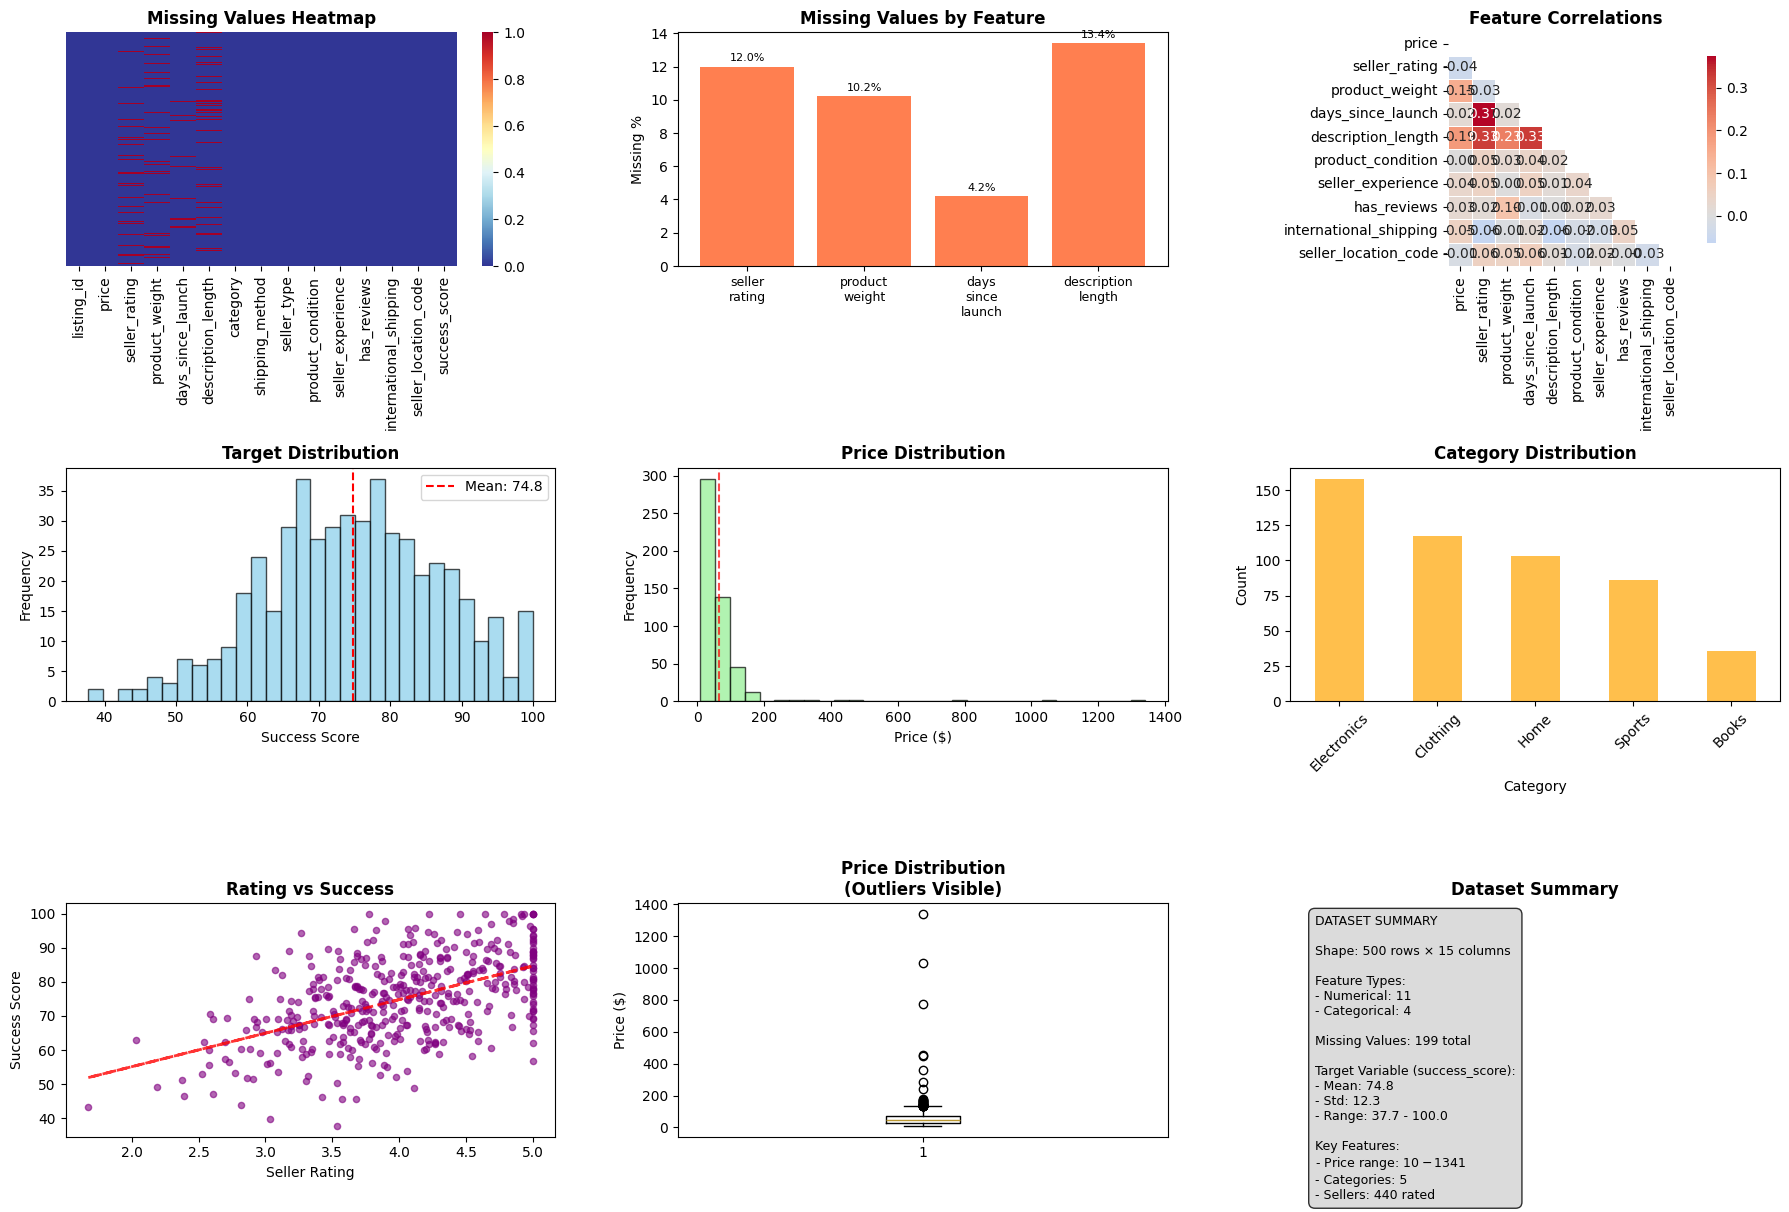


DATASET OVERVIEW:
   • Shape: 500 samples × 15 features
   • Missing values: 199 total
   • Most missing: seller_rating (12.0%)
   • Strongest correlation: seller_rating ↔ days_since_launch (r=0.375)


In [ ]:
def explore_data_with_visualizations(df):
    """
    Comprehensive EDA to identify preprocessing needs.
    """
    print("=" * 60)
    print("EXPLORATORY DATA ANALYSIS")
    print("=" * 60)

    # Create comprehensive EDA dashboard
    create_eda_dashboard(df)

    # Extract key insights
    missing_counts = df.isnull().sum()
    missing_features = missing_counts[missing_counts > 0]
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'success_score' in numerical_cols:
        numerical_cols.remove('success_score')

    print(f"\nDATASET OVERVIEW:")
    print(f"   • Shape: {df.shape[0]:,} samples × {df.shape[1]} features")
    print(f"   • Missing values: {df.isnull().sum().sum():,} total")

    if len(missing_features) > 0:
        missing_pct = (missing_features / len(df)) * 100
        print(f"   • Most missing: {missing_features.index[0]} ({missing_pct.iloc[0]:.1f}%)")

    if len(numerical_cols) > 1:
        corr_matrix = df[numerical_cols].corr()
        corr_matrix_abs = corr_matrix.abs()
        np.fill_diagonal(corr_matrix_abs.values, 0)
        max_corr = corr_matrix_abs.max().max()
        max_corr_pair = corr_matrix_abs.stack().idxmax()
        print(f"   • Strongest correlation: {max_corr_pair[0]} ↔ {max_corr_pair[1]} (r={max_corr:.3f})")

    print("=" * 60)

# Run exploration
explore_data_with_visualizations(dataset)

---
## Step 3: Missing Values Handling

Handle missing values using different imputation strategies.

**Key Concepts:**
- **Mean imputation**: Replace with average (sensitive to outliers)
- **Median imputation**: Replace with middle value (robust)
- **Mode imputation**: Replace with most frequent value
- **Drop strategy**: Remove rows with missing data
---

# Exercise

- Implement missing strategies: `'mean'`, `'drop'`
- Try different strategies and compare their differences

HANDLING MISSING VALUES (Strategy: MEDIAN)
--------------------------------------------------
Missing values in 4 features
Missing values: 199 → 0


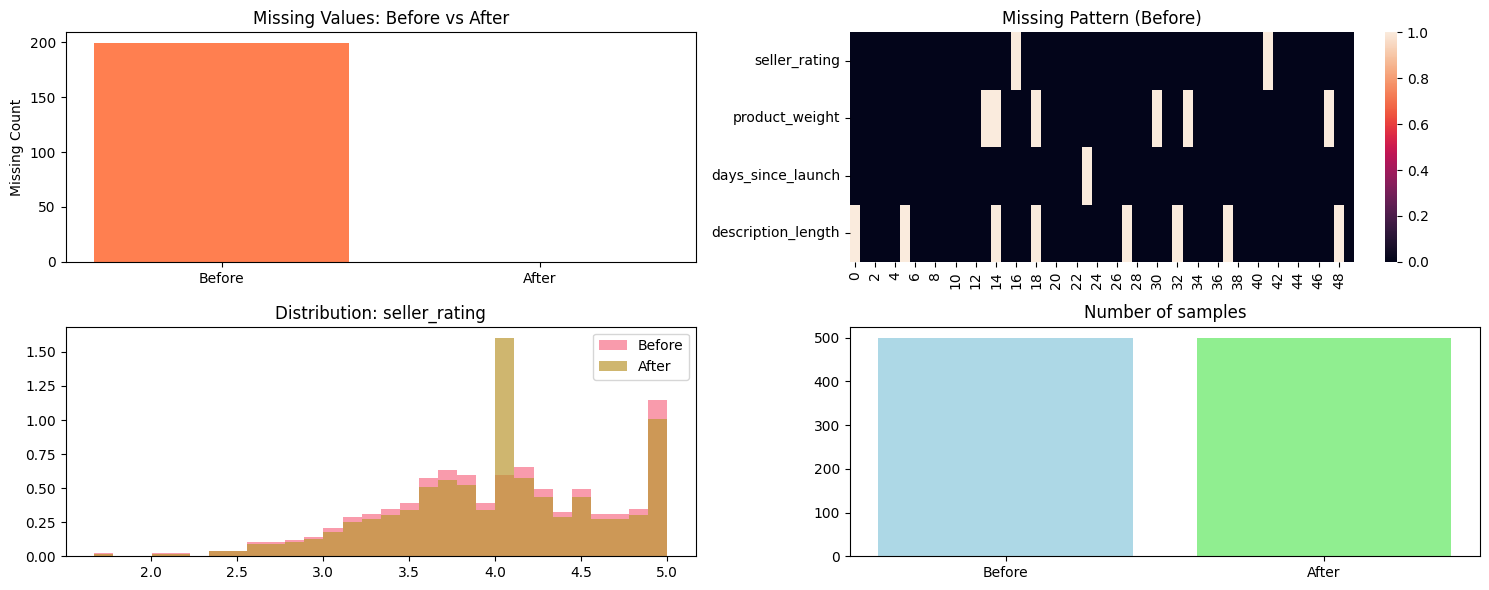

In [ ]:
def handle_missing_values(df, strategy='median'):
    """
    Handle missing values using different imputation strategies.
    """
    print(f"HANDLING MISSING VALUES (Strategy: {strategy.upper()})")
    print("-" * 50)

    df_processed = df.copy()
    original_missing = df.isnull().sum()
    features_with_missing = original_missing[original_missing > 0]

    if len(features_with_missing) == 0:
        print("No missing values found!")
        return df_processed

    print(f"Missing values in {len(features_with_missing)} features")

    # Apply strategy
    for feature in features_with_missing.index:
        if strategy == 'drop':
            df_processed = df_processed.dropna(subset=[feature])
            continue

        if df[feature].dtype == 'object':
            fill_value = df[feature].mode().iloc[0] if len(df[feature].mode()) > 0 else 'Unknown'
        else:
            if strategy == 'mean':
                fill_value = df[feature].mean()
            elif strategy == 'median':
                fill_value = df[feature].median()
            elif strategy == 'mode':
                fill_value = df[feature].mode().iloc[0] if len(df[feature].mode()) > 0 else df[feature].mean()
            else:
                fill_value = df[feature].median()

        df_processed[feature] = df_processed[feature].fillna(fill_value)

    final_missing = df_processed.isnull().sum()
    print(f"Missing values: {original_missing.sum()} → {final_missing.sum()}")

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 6))

    # Before/after comparison
    axes[0][0].bar(['Before', 'After'], [original_missing.sum(), final_missing.sum()],
               color=['coral', 'lightgreen'])
    axes[0][0].set_title('Missing Values: Before vs After')
    axes[0][0].set_ylabel('Missing Count')

    # Missing pattern
    if len(features_with_missing) > 0:
        sns.heatmap(df[features_with_missing.index].isnull().head(50).T,
                   ax=axes[0][1], cbar=True, yticklabels=True)
        axes[0][1].set_title('Missing Pattern (Before)')

    # Distribution comparison
    numerical_missing = [col for col in features_with_missing.index
                        if df[col].dtype in ['int64', 'float64']]
    if len(numerical_missing) > 0:
        feature = numerical_missing[0]
        axes[1][0].hist(df[feature].dropna(), bins=30, alpha=0.7, label='Before', density=True)
        axes[1][0].hist(df_processed[feature].dropna(), bins=30, alpha=0.7, label='After', density=True)
        axes[1][0].set_title(f'Distribution: {feature}')
        axes[1][0].legend()

    # Dropped rows
    axes[1][1].bar(['Before', 'After'], [df.shape[0], df_processed.shape[0]],
                   color=['lightblue', 'lightgreen'])
    axes[1][1].set_title(f'Number of samples')

    plt.tight_layout()
    plt.show()

    return df_processed

# Apply missing value handling - MODIFY strategy to experiment!
dataset_step1 = handle_missing_values(dataset, strategy='median')

---
## Step 4: Categorical Encoding

Encode categorical features using appropriate methods.

**Key Concepts:**
- **One-hot encoding**: For nominal features (no order)
- **Ordinal encoding**: For ranked features (already done)

**Feature Types:**
- Nominal: category, shipping_method, seller_type
- Ordinal: product_condition, seller_experience

---

#Exercise
Implement one-hot encoding

*Hint: Use the following function: [pandas.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)*

ENCODING CATEGORICAL FEATURES
--------------------------------------------------
One-hot encoding: category, shipping_method, seller_type
Ordinal features (already encoded): product_condition, seller_experience
Features: 15 → 23
New features created: 11


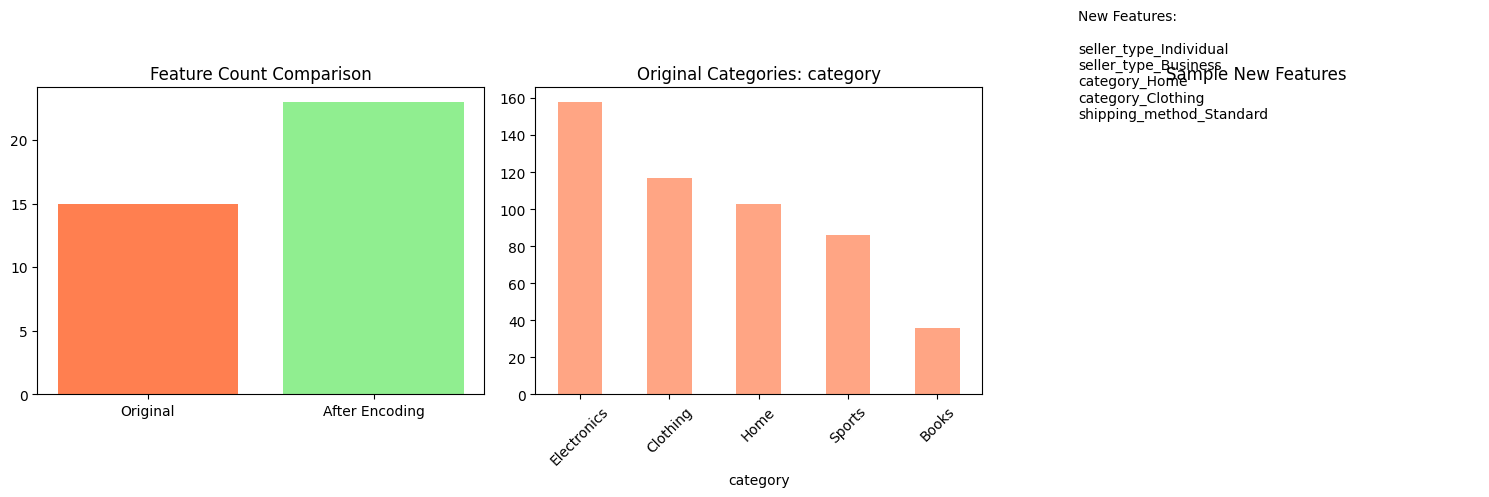

In [ ]:
def encode_categorical_features(df):
    """
    Encode categorical features using appropriate methods.
    """
    print("ENCODING CATEGORICAL FEATURES")
    print("-" * 50)

    df_processed = df.copy()
    original_columns = set(df.columns)

    # Feature types
    nominal_features = ['category', 'shipping_method', 'seller_type']
    ordinal_features = ['product_condition', 'seller_experience']

    # One-hot encode nominal features
    nominal_to_encode = [f for f in nominal_features if f in df.columns]
    if nominal_to_encode:
        print(f"One-hot encoding: {', '.join(nominal_to_encode)}")
        df_processed = pd.get_dummies(df_processed, columns=nominal_to_encode, prefix=nominal_to_encode)

    # Ordinal features already encoded
    ordinal_present = [f for f in ordinal_features if f in df.columns]
    if ordinal_present:
        print(f"Ordinal features (already encoded): {', '.join(ordinal_present)}")

    new_columns = set(df_processed.columns)
    added_columns = new_columns - original_columns

    print(f"Features: {len(original_columns)} → {len(new_columns)}")
    print(f"New features created: {len(added_columns)}")

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Feature count comparison
    axes[0].bar(['Original', 'After Encoding'], [len(original_columns), len(new_columns)],
               color=['coral', 'lightgreen'])
    axes[0].set_title('Feature Count Comparison')

    # Original categories
    if nominal_to_encode:
        feature = nominal_to_encode[0]
        df[feature].value_counts().plot(kind='bar', ax=axes[1], color='coral', alpha=0.7)
        axes[1].set_title(f'Original Categories: {feature}')
        axes[1].tick_params(axis='x', rotation=45)

    # New features sample
    if added_columns:
        sample_features = list(added_columns)[:5]
        text_content = "New Features:\n\n" + "\n".join(sample_features)
        axes[2].text(0.1, 0.9, text_content, transform=axes[2].transAxes, fontsize=10)
        axes[2].set_title('Sample New Features')
        axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return df_processed

# Apply categorical encoding
dataset_step2 = encode_categorical_features(dataset_step1)

---
## Step 5: Feature Scaling

Scale numerical features using different methods.

**Key Concepts:**
- **Standard scaling**: Z-score normalization (mean=0, std=1)
- **MinMax scaling**: Scale to 0-1 range
- **Robust scaling**: Uses median and IQR (outlier-resistant)

---
# Exercise
- Read [scikit-learn documentation](https://scikit-learn.org/stable/api/sklearn.preprocessing.html) and implement minmax and robust scalers.
- Try different scalers and their effect on the range of values

SCALING NUMERICAL FEATURES (Method: ROBUST)
--------------------------------------------------
Features to scale: price, seller_rating, product_weight, days_since_launch, description_length
Scaled 5 features


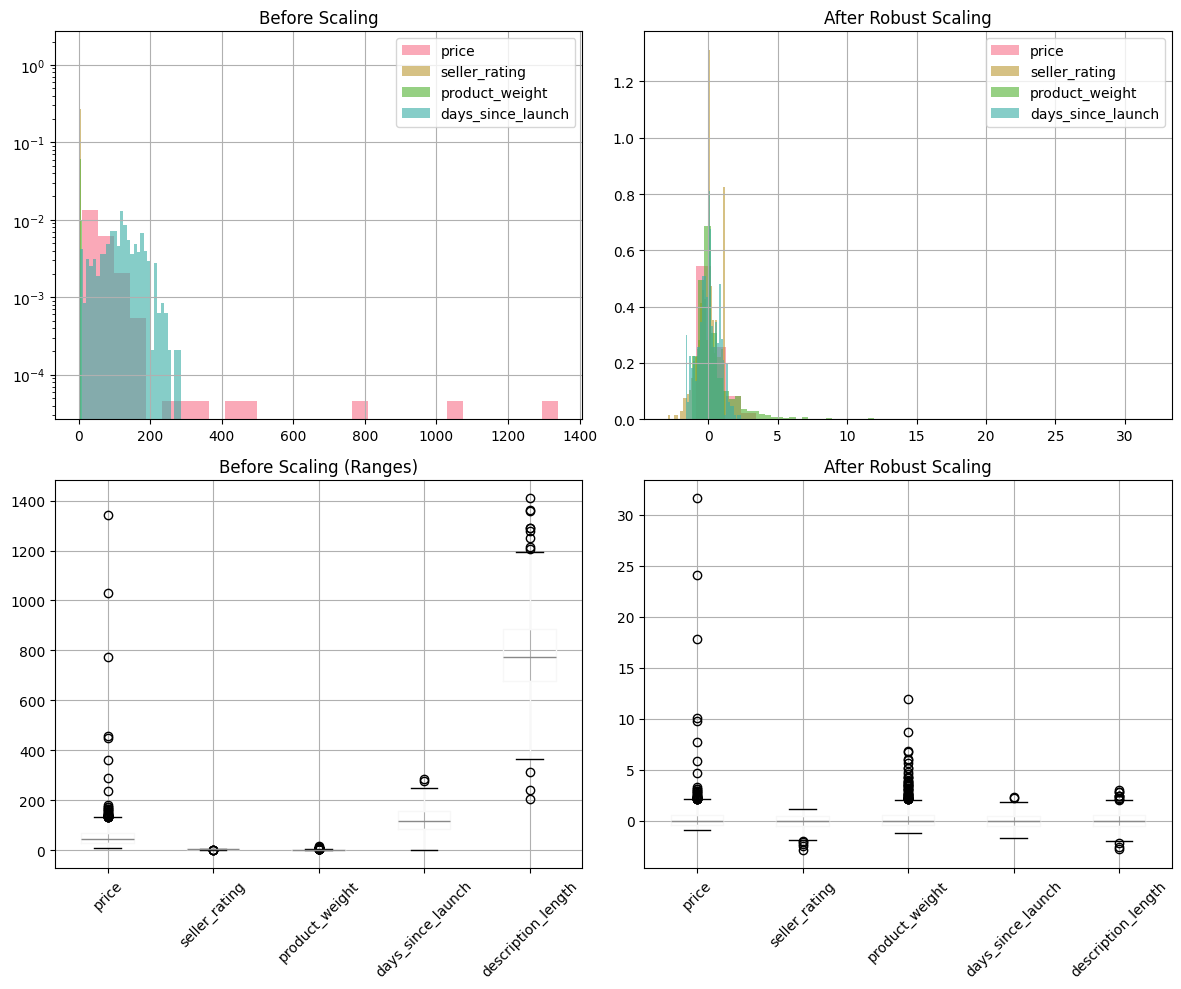

In [ ]:
def scale_numerical_features(df, scaler_type='standard'):
    """
    Scale numerical features using different methods.
    """
    print(f"SCALING NUMERICAL FEATURES (Method: {scaler_type.upper()})")
    print("-" * 50)

    df_processed = df.copy()

    # Features to scale (exclude target and binary)
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    features_to_exclude = ['success_score', 'product_condition', 'seller_experience',
                          'has_reviews', 'international_shipping', 'seller_location_code']
    features_to_scale = [f for f in numerical_features if f not in features_to_exclude]

    if not features_to_scale:
        print("No numerical features to scale")
        return df_processed, None

    print(f"Features to scale: {', '.join(features_to_scale)}")

    # Select scaler
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'robust':
        scaler = RobustScaler()
    else:
        scaler = StandardScaler()

    # Apply scaling
    scaled_values = scaler.fit_transform(df_processed[features_to_scale])
    df_processed[features_to_scale] = scaled_values

    print(f"Scaled {len(features_to_scale)} features")

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Before scaling distributions
    for i, feature in enumerate(features_to_scale[:4]):
        df[feature].dropna().hist(bins=30, alpha=0.6, ax=axes[0,0], label=feature, density=True)
    axes[0,0].set_title('Before Scaling')
    axes[0,0].legend()
    axes[0,0].set_yscale('log')

    # After scaling distributions
    for i, feature in enumerate(features_to_scale[:4]):
        df_processed[feature].dropna().hist(bins=30, alpha=0.6, ax=axes[0,1], label=feature, density=True)
    axes[0,1].set_title(f'After {scaler_type.title()} Scaling')
    axes[0,1].legend()

    # Before scaling boxplots
    df[features_to_scale].boxplot(ax=axes[1,0])
    axes[1,0].set_title('Before Scaling (Ranges)')
    axes[1,0].tick_params(axis='x', rotation=45)

    # After scaling boxplots
    df_processed[features_to_scale].boxplot(ax=axes[1,1])
    axes[1,1].set_title(f'After {scaler_type.title()} Scaling')
    axes[1,1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return df_processed, scaler

# Apply feature scaling - MODIFY scaler_type to experiment!
dataset_step3, scaler = scale_numerical_features(dataset_step2, scaler_type='robust')

---
## Step 6: Outlier Detection and Handling

Detect and handle outliers using multiple statistical methods.

**Key Concepts:**
- **IQR Method**: Uses interquartile range (Q3-Q1)
- **Z-Score Method**: Uses standard deviations from mean
- **Isolation Forest**: ML approach for anomaly detection


---
#Exercise
- Actions: `'remove'`, `'cap'`, `'keep'`
- Try different combinations: methods × actions

OUTLIER DETECTION & HANDLING
Method: IQR | Action: CAP
--------------------------------------------------
Checking 5 numerical features
   • price: 33 outliers (6.6%)
   • seller_rating: 5 outliers (1.0%)
   • product_weight: 51 outliers (10.2%)
   • days_since_launch: 2 outliers (0.4%)
   • description_length: 12 outliers (2.4%)

Total outliers: 94 (18.8%)
Capping outliers...


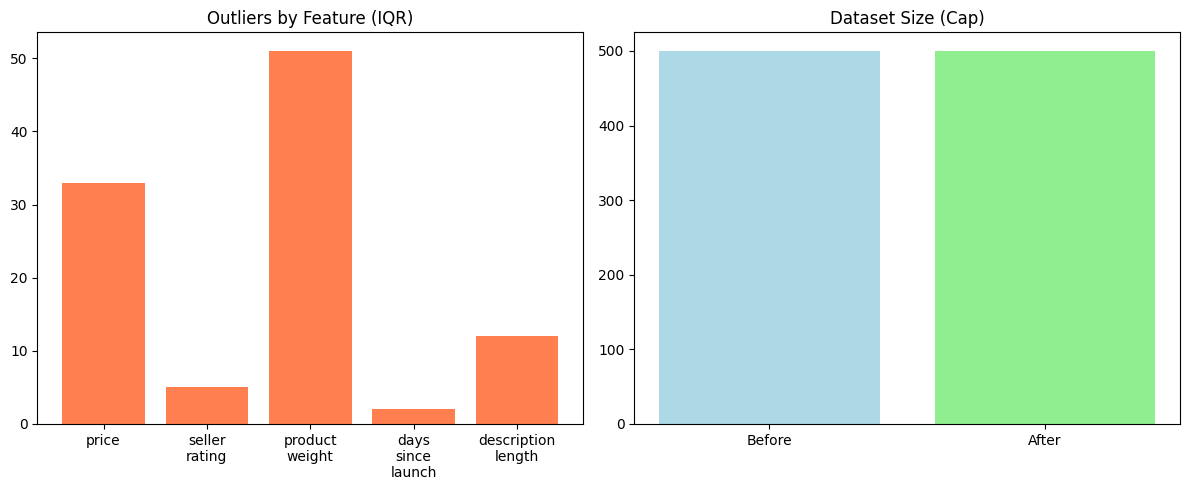

Dataset shape: (500, 23) → (500, 23)

Try: method='zscore', action='remove'


In [ ]:
def detect_and_handle_outliers(df, method='iqr', action='cap'):
    """
    Detect and handle outliers using different methods and actions.
    """
    print(f"OUTLIER DETECTION & HANDLING")
    print(f"Method: {method.upper()} | Action: {action.upper()}")
    print("-" * 50)

    df_processed = df.copy()
    original_shape = df.shape

    # Get numerical features (exclude target and binary)
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    features_to_check = [f for f in numerical_features if f not in
                        ['success_score', 'product_condition', 'seller_experience',
                         'has_reviews', 'international_shipping', 'seller_location_code']]

    if not features_to_check:
        print("No numerical features found")
        return df_processed

    print(f"Checking {len(features_to_check)} numerical features")

    all_outlier_indices = set()
    outlier_summary = {}

    # Detect outliers
    for feature in features_to_check:
        data = df[feature].dropna()
        if len(data) == 0:
            continue

        if method == 'iqr':
            Q1, Q3 = data.quantile(0.25), data.quantile(0.75)
            IQR = Q3 - Q1
            outlier_mask = (data < Q1 - 1.5 * IQR) | (data > Q3 + 1.5 * IQR)
            outlier_indices = set(data[outlier_mask].index)

        elif method == 'zscore':
            z_scores = np.abs(stats.zscore(data))
            outlier_indices = set(data[z_scores > 3].index)

        elif method == 'isolation_forest':
            iso_forest = IsolationForest(contamination=0.1, random_state=42)
            outlier_mask = iso_forest.fit_predict(data.values.reshape(-1, 1)) == -1
            outlier_indices = set(data[outlier_mask].index)

        outlier_count = len(outlier_indices)
        outlier_pct = (outlier_count / len(data)) * 100 if len(data) > 0 else 0
        outlier_summary[feature] = {'count': outlier_count, 'percentage': outlier_pct}
        all_outlier_indices.update(outlier_indices)

        print(f"   • {feature}: {outlier_count} outliers ({outlier_pct:.1f}%)")

    total_outliers = len(all_outlier_indices)
    print(f"\nTotal outliers: {total_outliers} ({(total_outliers/len(df)*100):.1f}%)")

    # Apply action
    if action == 'remove' and total_outliers > 0:
        df_processed = df_processed.drop(index=list(all_outlier_indices))
        print(f"Removed {total_outliers} outlier rows")

    elif action == 'cap' and total_outliers > 0:
        print(f"Capping outliers...")
        for feature in features_to_check:
            if outlier_summary[feature]['count'] > 0:
                Q1, Q3 = df[feature].quantile(0.25), df[feature].quantile(0.75)
                IQR = Q3 - Q1
                df_processed[feature] = df_processed[feature].clip(
                    lower=Q1 - 1.5 * IQR, upper=Q3 + 1.5 * IQR)

    elif action == 'keep':
        print(f"Keeping all outliers")

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Outlier counts
    if outlier_summary:
        features = list(outlier_summary.keys())
        counts = [outlier_summary[f]['count'] for f in features]
        axes[0].bar(range(len(features)), counts, color='coral')
        axes[0].set_xticks(range(len(features)))
        axes[0].set_xticklabels([f.replace('_', '\n') for f in features], rotation=0)
        axes[0].set_title(f'Outliers by Feature ({method.upper()})')

    # Before/after comparison
    if total_outliers > 0 and action != 'keep':
        axes[1].bar(['Before', 'After'], [original_shape[0], df_processed.shape[0]],
                   color=['lightblue', 'lightgreen'])
        axes[1].set_title(f'Dataset Size ({action.title()})')
    else:
        axes[1].text(0.5, 0.5, 'No Action Taken', ha='center', va='center',
                    transform=axes[1].transAxes, fontsize=12)
        axes[1].set_title('Action Impact')

    plt.tight_layout()
    plt.show()

    print(f"Dataset shape: {original_shape} → {df_processed.shape}")
    return df_processed

# Apply outlier detection - MODIFY parameters to experiment!
dataset_step4 = detect_and_handle_outliers(dataset_step3, method='iqr', action='cap')

print("\nTry: method='zscore', action='remove'")

---
## Step 7: Complete Preprocessing Pipeline

Build an end-to-end preprocessing pipeline that applies all steps automatically.

**Pipeline Steps:**
1. Data validation
2. Missing value imputation
3. Categorical encoding
4. Feature scaling
5. Outlier handling
6. Final validation

---
# Exercise
Set the configuration for your preferred combination of preprocessing operations and generate the dataset for training.

COMPLETE PREPROCESSING PIPELINE
Input: (500, 15)

STEP 1: VALIDATION
   Missing values: 199

STEP 2: MISSING VALUES
HANDLING MISSING VALUES (Strategy: MEDIAN)
--------------------------------------------------
Missing values in 4 features
Missing values: 199 → 0


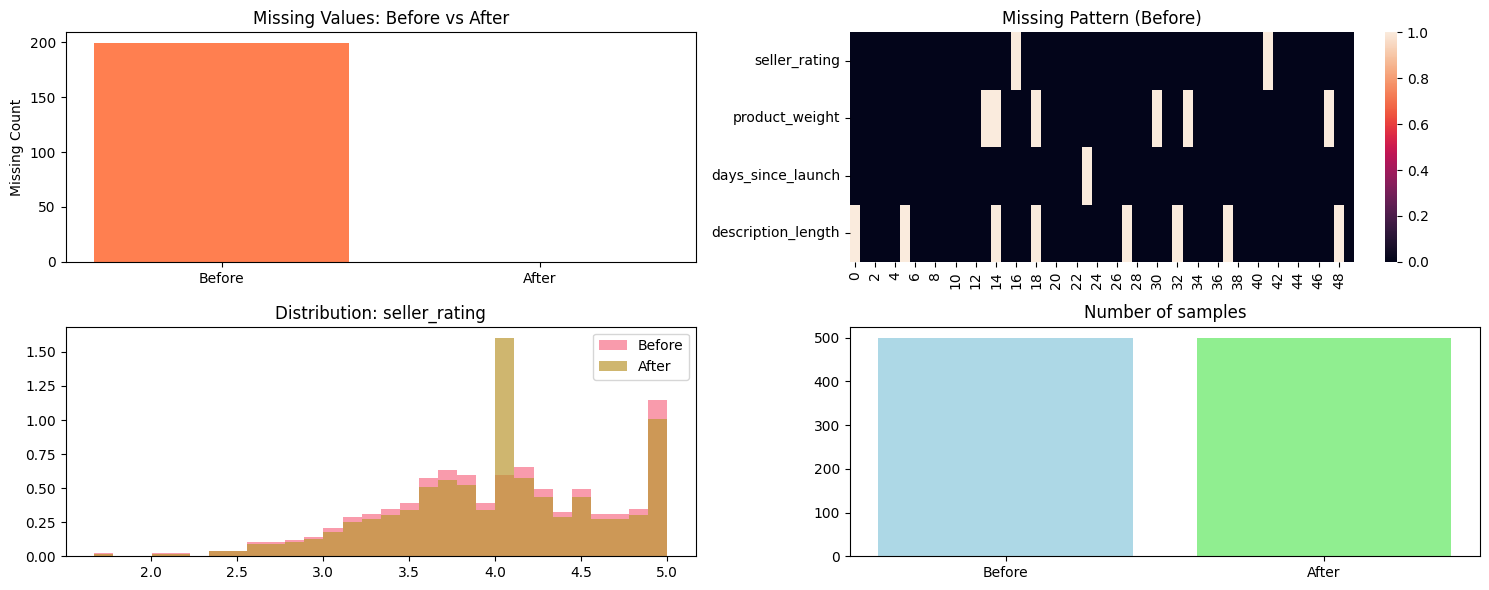


STEP 3: CATEGORICAL ENCODING
ENCODING CATEGORICAL FEATURES
--------------------------------------------------
One-hot encoding: category, shipping_method, seller_type
Ordinal features (already encoded): product_condition, seller_experience
Features: 15 → 23
New features created: 11


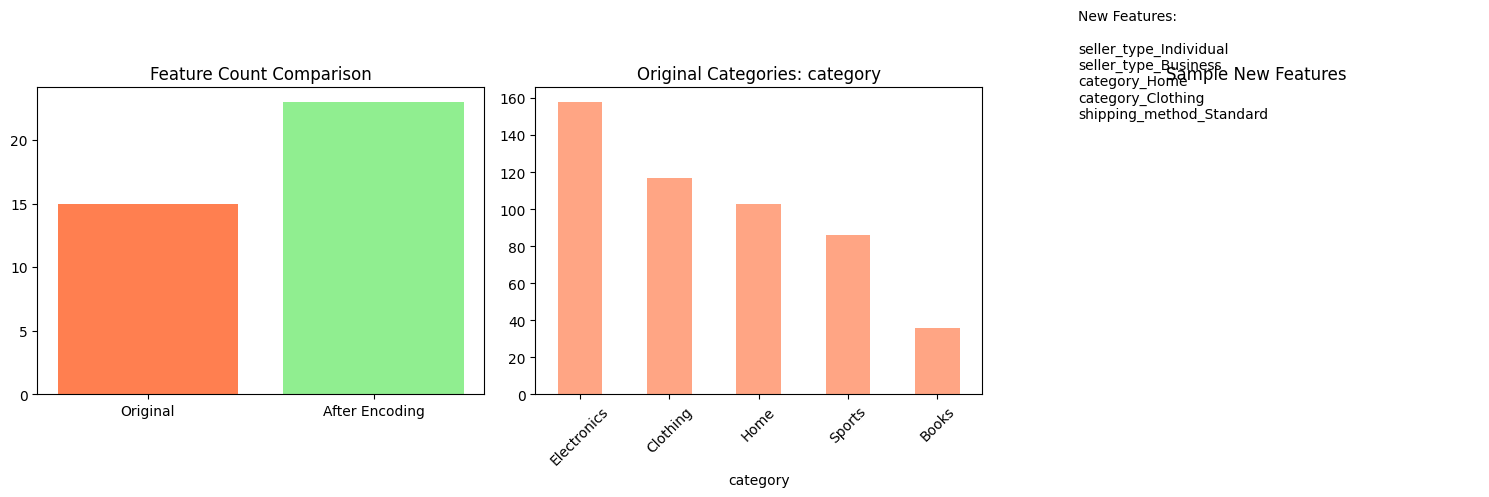


STEP 4: FEATURE SCALING
SCALING NUMERICAL FEATURES (Method: STANDARD)
--------------------------------------------------
Features to scale: price, seller_rating, product_weight, days_since_launch, description_length
Scaled 5 features


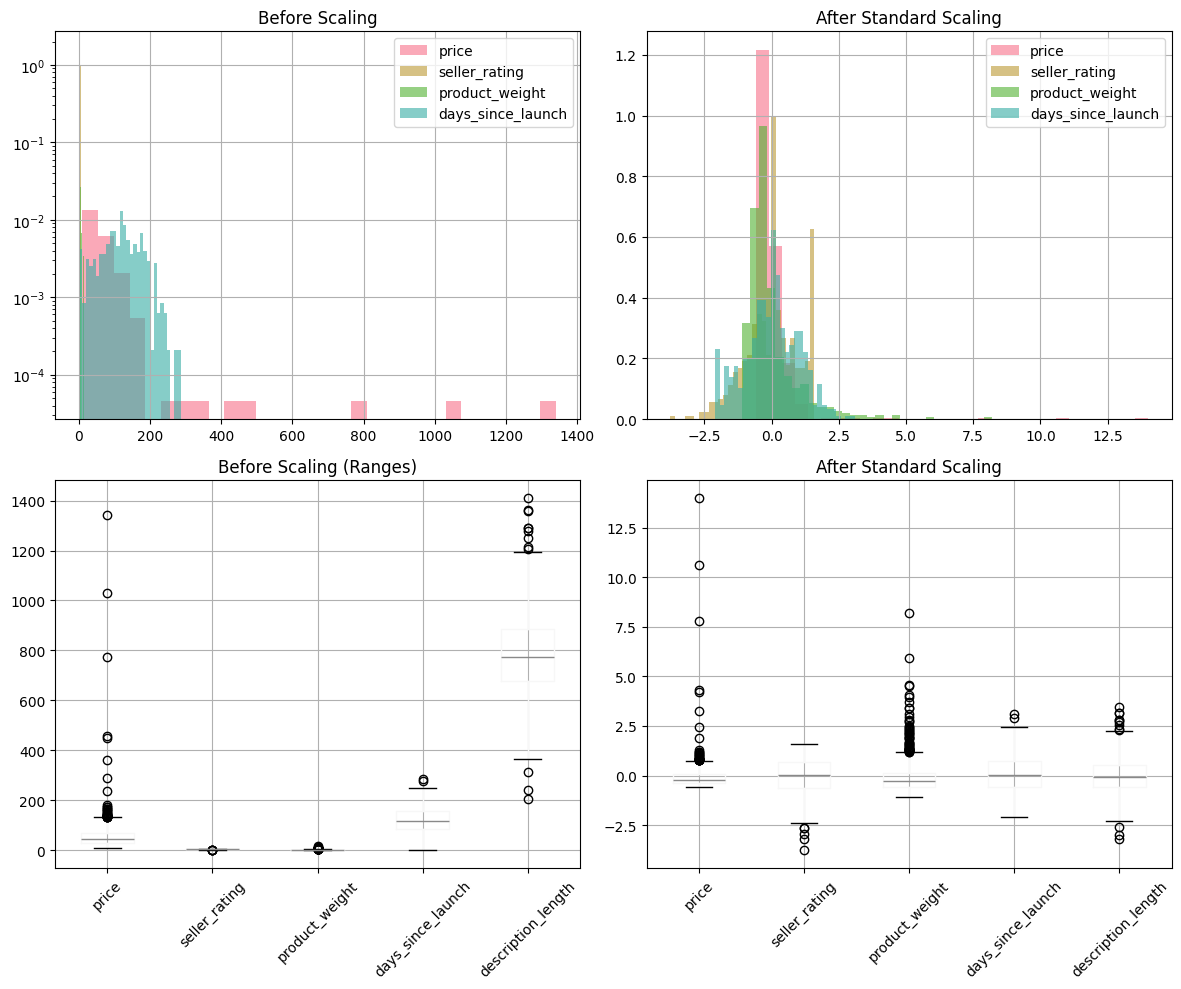


STEP 5: OUTLIERS
OUTLIER DETECTION & HANDLING
Method: IQR | Action: CAP
--------------------------------------------------
Checking 5 numerical features
   • price: 33 outliers (6.6%)
   • seller_rating: 5 outliers (1.0%)
   • product_weight: 51 outliers (10.2%)
   • days_since_launch: 2 outliers (0.4%)
   • description_length: 12 outliers (2.4%)

Total outliers: 94 (18.8%)
Capping outliers...


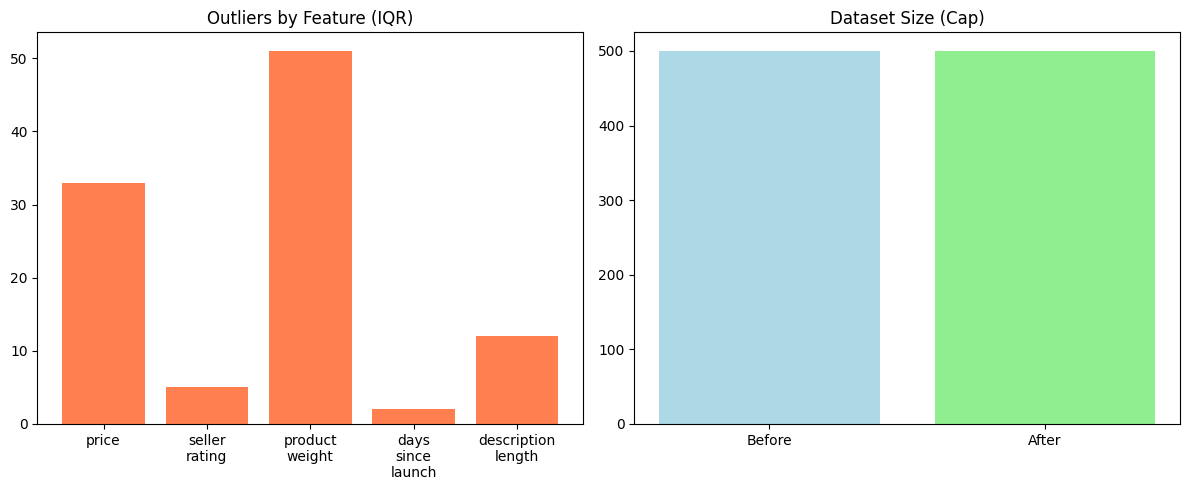

Dataset shape: (500, 23) → (500, 23)

PIPELINE SUMMARY
   1. Validation: 199 missing values
   2. Missing: median imputation
   3. Encoding: +8 features
   4. Scaling: standard
   5. Outliers: iqr + cap

COMPLETED: (500, 15) → (500, 23)
Dataset ready for modeling!

EXPERIMENT: Modify 'preprocessing_config' above!
   Try different combinations of parameters
   Disable steps by setting to False

FINAL DATASET: 'final_dataset' variable created
   Shape input X: (500, 21), shape output y: (500,)


In [ ]:
def create_preprocessing_pipeline(config):
    """
    Create a complete preprocessing pipeline.
    """
    def pipeline(df):
        print("="*60)
        print("COMPLETE PREPROCESSING PIPELINE")
        print("="*60)

        df_current = df.copy()
        original_shape = df.shape
        pipeline_log = []

        print(f"Input: {original_shape}")

        # Step 1: Validation
        print(f"\nSTEP 1: VALIDATION")
        missing_total = df_current.isnull().sum().sum()
        print(f"   Missing values: {missing_total}")
        pipeline_log.append(f"Validation: {missing_total} missing values")

        # Step 2: Missing Values
        if config.get('handle_missing', True):
            print(f"\nSTEP 2: MISSING VALUES")
            strategy = config.get('missing_strategy', 'median')
            df_current = handle_missing_values(df_current, strategy=strategy)
            pipeline_log.append(f"Missing: {strategy} imputation")

        # Step 3: Categorical Encoding
        if config.get('encode_categorical', True):
            print(f"\nSTEP 3: CATEGORICAL ENCODING")
            before_features = df_current.shape[1]
            df_current = encode_categorical_features(df_current)
            new_features = df_current.shape[1] - before_features
            pipeline_log.append(f"Encoding: +{new_features} features")

        # Step 4: Feature Scaling
        if config.get('scale_features', True):
            print(f"\nSTEP 4: FEATURE SCALING")
            scaler_type = config.get('scaler_type', 'standard')
            df_current, fitted_scaler = scale_numerical_features(df_current, scaler_type=scaler_type)
            pipeline_log.append(f"Scaling: {scaler_type}")
        else:
            fitted_scaler = None

        # Step 5: Outliers
        if config.get('handle_outliers', True):
            print(f"\nSTEP 5: OUTLIERS")
            method = config.get('outlier_method', 'iqr')
            action = config.get('outlier_action', 'cap')
            df_current = detect_and_handle_outliers(df_current, method=method, action=action)
            pipeline_log.append(f"Outliers: {method} + {action}")

        # Final Summary
        final_shape = df_current.shape
        print(f"\n" + "="*60)
        print("PIPELINE SUMMARY")
        print("="*60)
        for i, log in enumerate(pipeline_log, 1):
            print(f"   {i}. {log}")

        print(f"\nCOMPLETED: {original_shape} → {final_shape}")
        print(f"Dataset ready for modeling!")

        metadata = {
            'original_shape': original_shape,
            'final_shape': final_shape,
            'config': config,
            'scaler': fitted_scaler
        }

        return df_current, metadata

    return pipeline

# Configure pipeline - MODIFY these parameters!
preprocessing_config = {
    'handle_missing': True,
    'missing_strategy': 'median',      # 'mean', 'median', 'mode', 'drop'
    'encode_categorical': True,
    'scale_features': True,
    'scaler_type': 'standard',         # 'standard', 'minmax', 'robust'
    'handle_outliers': True,
    'outlier_method': 'iqr',          # 'iqr', 'zscore', 'isolation_forest'
    'outlier_action': 'cap'           # 'remove', 'cap', 'keep'
}

# Create and run pipeline
pipeline = create_preprocessing_pipeline(preprocessing_config)
final_dataset, metadata = pipeline(dataset)

print("\n" + "="*60)
print("EXPERIMENT: Modify 'preprocessing_config' above!")
print("   Try different combinations of parameters")
print("   Disable steps by setting to False")
print("="*60)

print(f"\nFINAL DATASET: 'final_dataset' variable created")

X = final_dataset.drop(['success_score', 'listing_id'], axis=1)  # Drop both target AND identifier
y = final_dataset['success_score']
print(f"   Shape input X: {X.shape}, shape output y: {y.shape}")


---
## Step 8: Linear Regression Models

Train and compare linear regression models: Linear, Ridge, and Lasso.

**Key Concepts:**
- **Linear Regression**: Simple linear relationship
- **Ridge Regression**: L2 regularization prevents overfitting
- **Lasso Regression**: L1 regularization enables feature selection

Learn more on the [scikit-learn documentation page.](https://scikit-learn.org/stable/modules/linear_model.html)

---
# Exercise
Modify regularization parameters and compare results!

TRAINING LINEAR REGRESSION MODELS
--------------------------------------------------
Data split: 400 train, 100 test samples

Training Linear Regression...
R² = 0.583, RMSE = 7.385
CV Score: 0.542 (±0.061)

Training Ridge Regression...
R² = 0.582, RMSE = 7.385
CV Score: 0.542 (±0.060)

Training Lasso Regression...
R² = 0.394, RMSE = 8.898
CV Score: 0.377 (±0.047)

BEST: Linear Regression (R² = 0.583)
Lasso zeroed out 15 features (feature selection)
Saved: linear_analysis.png


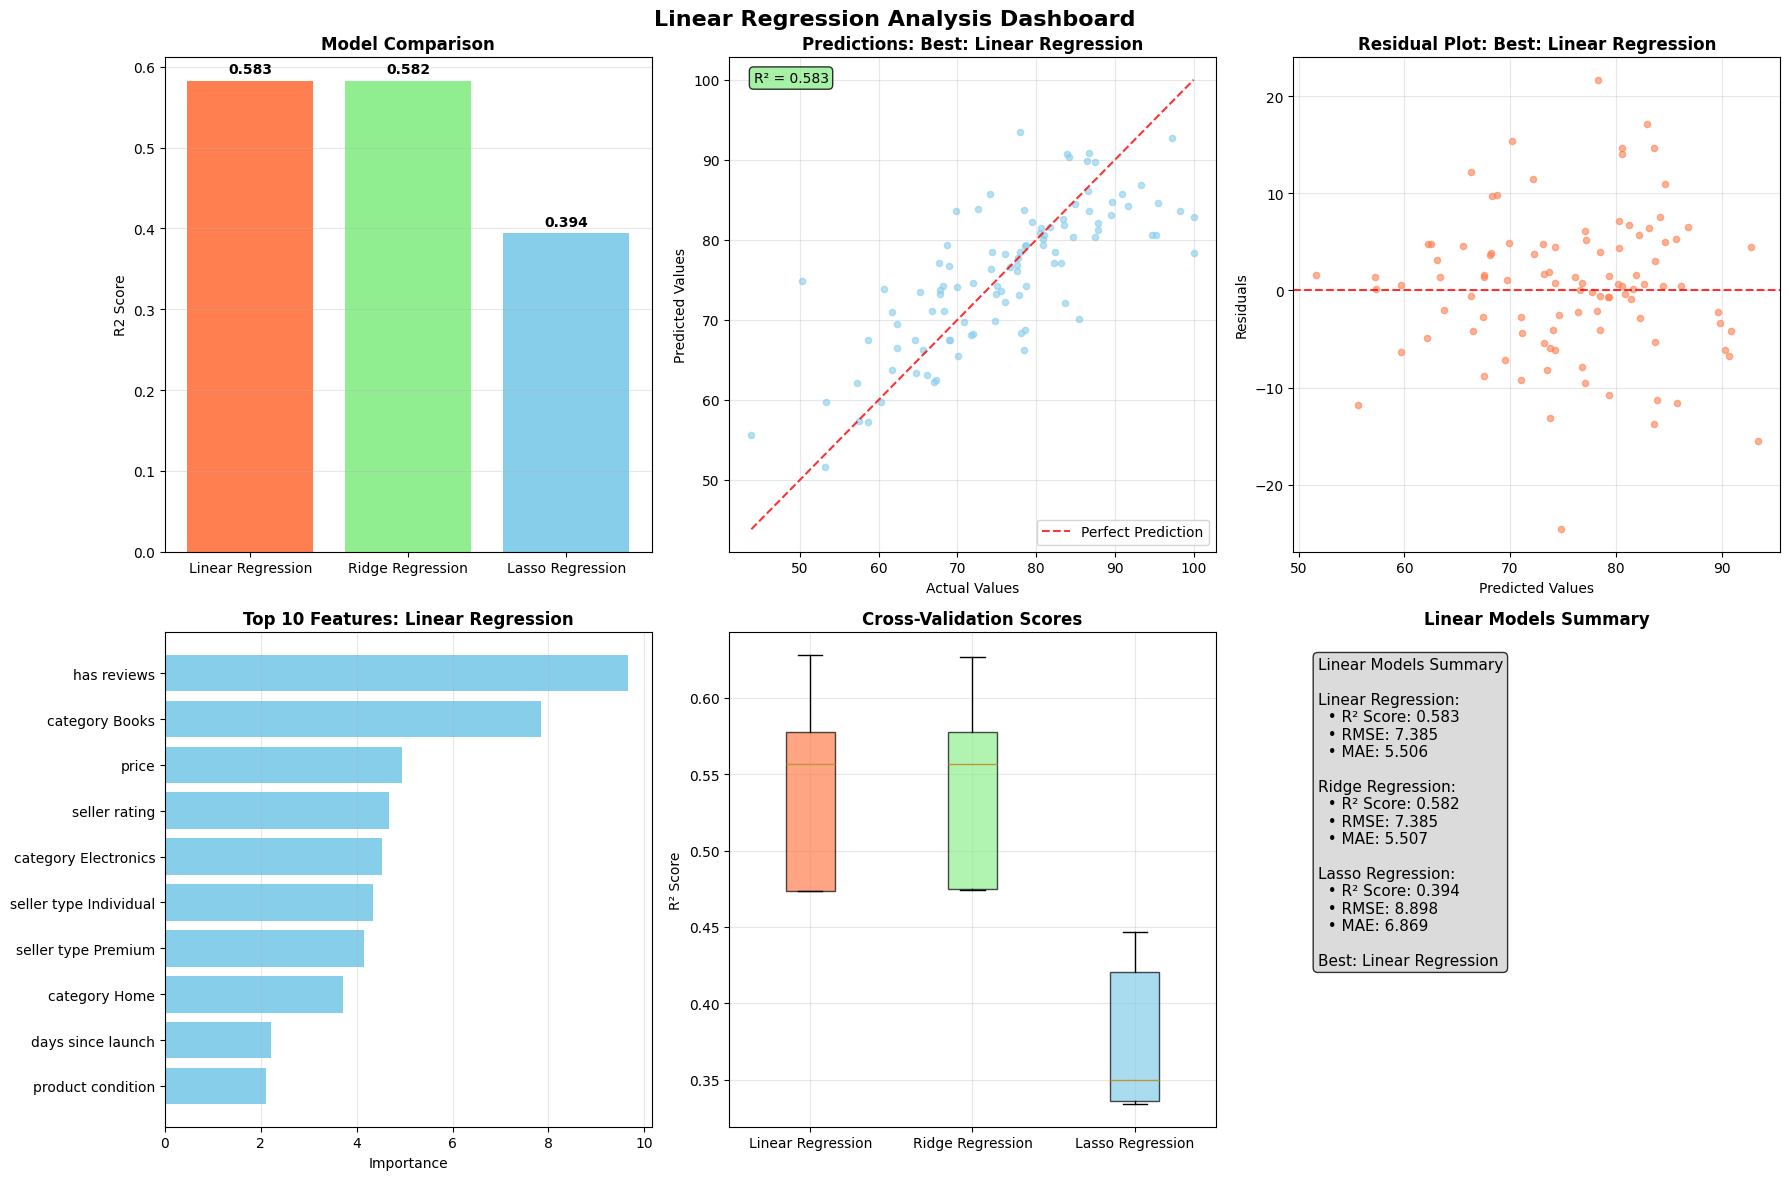

In [ ]:
def train_linear_regression(X, y, test_size=0.2, cv_folds=5, visualize=True):
    """
    Train and compare linear regression models.
    """
    print("TRAINING LINEAR REGRESSION MODELS")
    print("-" * 50)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_SEED)
    print(f"Data split: {X_train.shape[0]} train, {X_test.shape[0]} test samples")

    # Define models
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=1.0)
    }

    results = {}

    # Train each model
    for name, model in models.items():
        print(f"\nTraining {name}...")
        start_time = time.time()

        model.fit(X_train, y_train)
        training_time = time.time() - start_time

        y_pred = model.predict(X_test)

        # Calculate metrics
        metrics = {
            'r2': r2_score(y_test, y_pred),
            'mse': mean_squared_error(y_test, y_pred),
            'mae': mean_absolute_error(y_test, y_pred)
        }

        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='r2')

        results[name] = {
            'model': model,
            'metrics': metrics,
            'cv_scores': cv_scores,
            'training_time': training_time,
            'y_pred': y_pred,
            'y_test': y_test
        }

        print(f"R² = {metrics['r2']:.3f}, RMSE = {np.sqrt(metrics['mse']):.3f}")
        print(f"CV Score: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

    # Find best model
    best_model_name = max(results.keys(), key=lambda x: results[x]['metrics']['r2'])
    print(f"\nBEST: {best_model_name} (R² = {results[best_model_name]['metrics']['r2']:.3f})")

    # Model insights
    lasso_model = results['Lasso Regression']['model']
    if hasattr(lasso_model, 'coef_'):
        zero_coefs = np.sum(np.abs(lasso_model.coef_) < 1e-10)
        print(f"Lasso zeroed out {zero_coefs} features (feature selection)")

    if visualize:
        create_linear_regression_dashboard(results, X_test, y_test)

    return results

linear_results = train_linear_regression(X, y, visualize=True)

---
## Step 9: XGBoost Regression

Train XGBoost model with hyperparameter tuning.

**Key Concepts:**
- **Gradient Boosting**: Sequential model building
- **Hyperparameters**: n_estimators, max_depth, learning_rate
- **Feature Importance**: Tree-based feature ranking

---
# Exercise
- Instantiate the XGBoost regressor.
 - *Hint: documentation on the [XGBoost webpage](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor)*


TRAINING XGBOOST REGRESSION MODEL
--------------------------------------------------
Data split: 400 train, 100 test samples
Hyperparameter search iterations: 15

Starting hyperparameter optimization...
Computing SHAP values...

XGBoost TRAINING COMPLETED!
R² Score: 0.476
RMSE: 8.274
CV Score: 0.447 (±0.062)
Training time: 28.01s

 BEST HYPERPARAMETERS:
   • subsample: 0.8
   • n_estimators: 100
   • max_depth: 4
   • learning_rate: 0.1

 TOP 3 FEATURES:
   1. has_reviews: 0.151
   2. category_Books: 0.146
   3. seller_rating: 0.100
Saved: xgboost_analysis.png


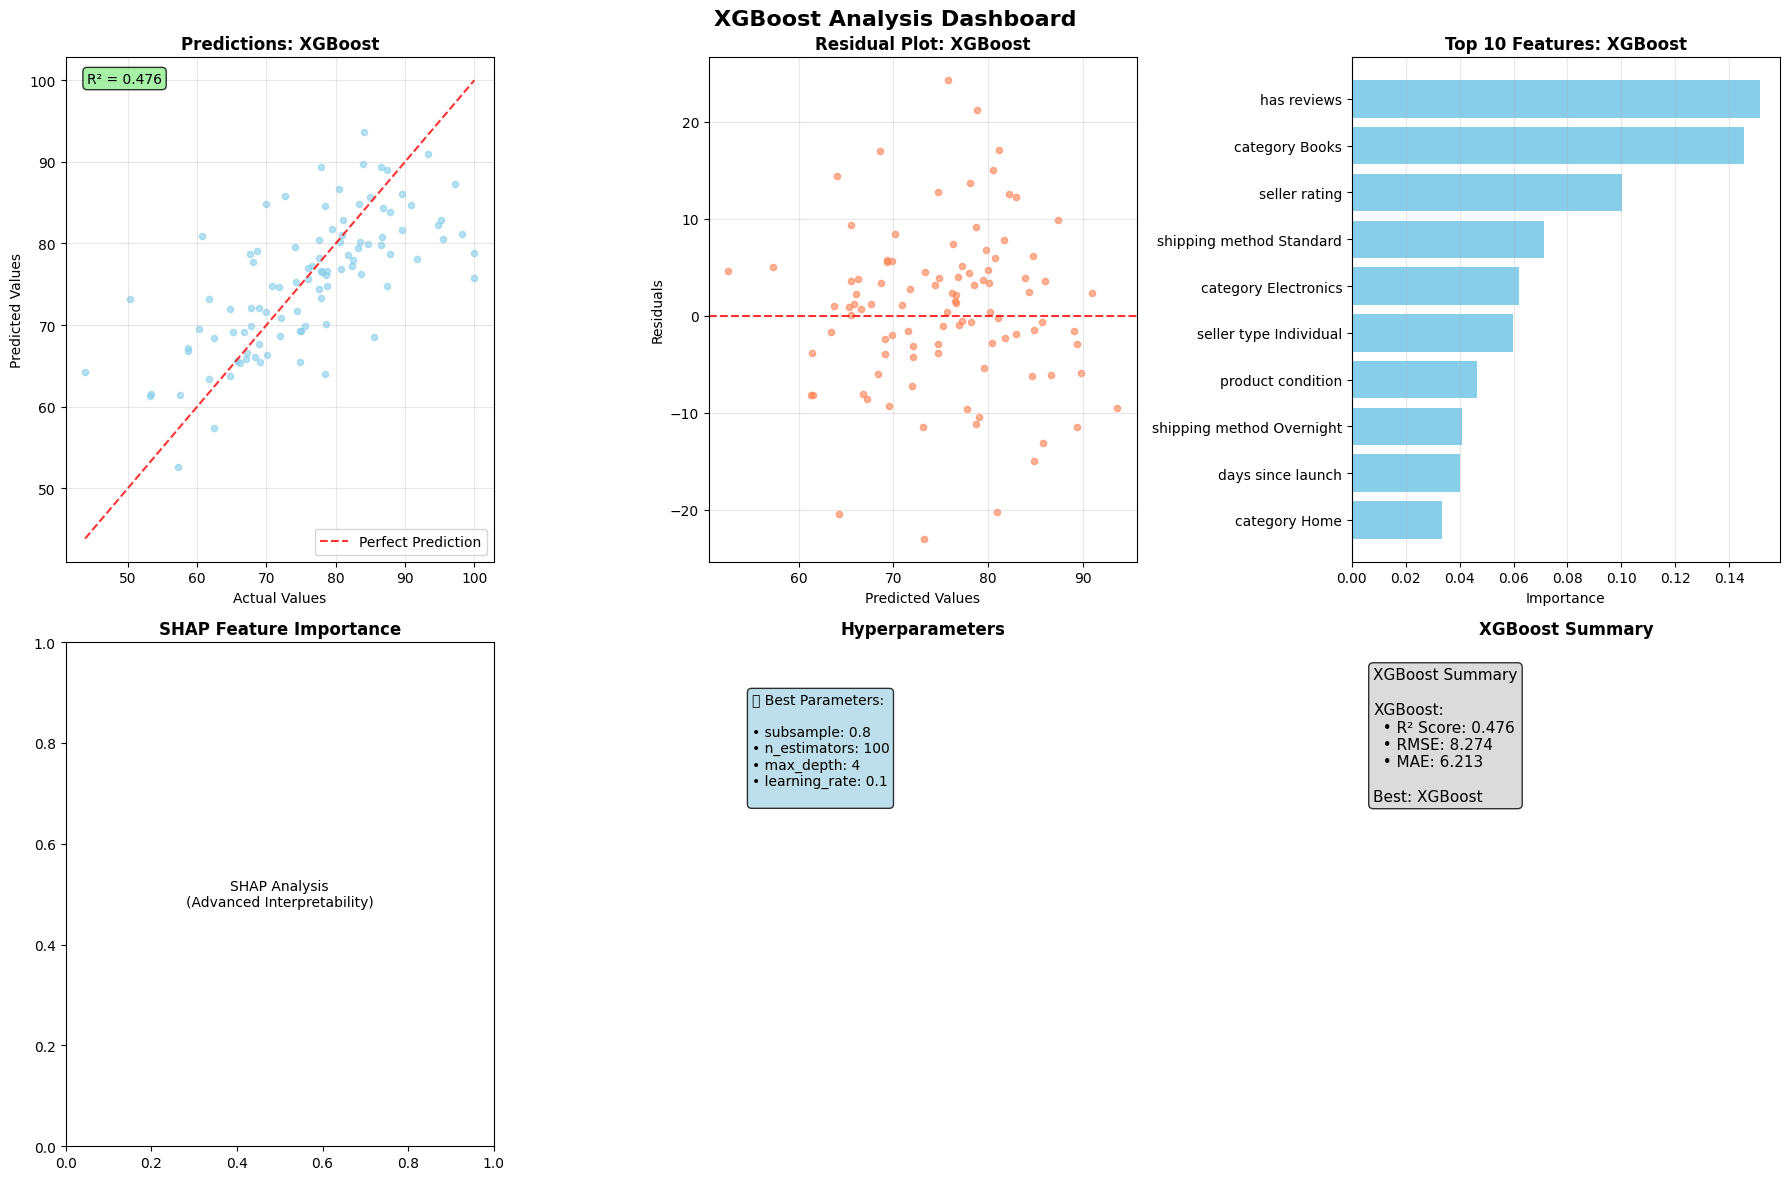

In [ ]:
def train_xgboost_regression(X, y, test_size=0.2, cv_folds=5, n_iter=20, visualize=True):
    """
    Train XGBoost regression model with hyperparameter tuning.
    """
    print("TRAINING XGBOOST REGRESSION MODEL")
    print("-" * 50)

    # Handle XGBoost availability
    if not XGBOOST_AVAILABLE:
        print("Using RandomForest instead of XGBoost")
        model_class = RandomForestRegressor
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7, None],
            'min_samples_split': [2, 5, 10]
        }
        model_name = "RandomForest"
    else:
        model_class = xgb.XGBRegressor
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 4, 5, 6],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0]
        }
        model_name = "XGBoost"

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_SEED)
    print(f"Data split: {X_train.shape[0]} train, {X_test.shape[0]} test samples")
    print(f"Hyperparameter search iterations: {n_iter}")

    start_time = time.time()

    # Hyperparameter search
    base_model = model_class(random_state=RANDOM_SEED, n_jobs=-1)
    random_search = RandomizedSearchCV(
        base_model, param_grid, n_iter=n_iter, cv=cv_folds,
        scoring='r2', random_state=42, n_jobs=-1
    )

    print(f"\nStarting hyperparameter optimization...")
    random_search.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Get best model
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Calculate metrics
    metrics = {
        'r2': r2_score(y_test, y_pred),
        'mse': mean_squared_error(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred)
    }

    cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv_folds, scoring='r2')

    # SHAP values (if available)
    shap_values = None
    if SHAP_AVAILABLE and XGBOOST_AVAILABLE:
        try:
            print(f"Computing SHAP values...")
            sample_size = min(100, X_test.shape[0])
            X_sample = X_test.iloc[:sample_size] if hasattr(X_test, 'iloc') else X_test[:sample_size]
            explainer = shap.TreeExplainer(best_model)
            shap_values = explainer.shap_values(X_sample)
        except:
            print(f"SHAP computation failed")

    # Store results
    results = {
        'model': best_model,
        'metrics': metrics,
        'cv_scores': cv_scores,
        'training_time': training_time,
        'best_params': random_search.best_params_,
        'best_cv_score': random_search.best_score_,
        'shap_values': shap_values,
        'y_pred': y_pred,
        'y_test': y_test
    }

    # Print results
    print(f"\n{model_name} TRAINING COMPLETED!")
    print(f"R² Score: {metrics['r2']:.3f}")
    print(f"RMSE: {np.sqrt(metrics['mse']):.3f}")
    print(f"CV Score: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
    print(f"Training time: {training_time:.2f}s")

    print(f"\n BEST HYPERPARAMETERS:")
    for param, value in random_search.best_params_.items():
        print(f"   • {param}: {value}")

    # Feature importance
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        top_features = np.argsort(importances)[-3:][::-1]
        print(f"\n TOP 3 FEATURES:")
        feature_names = getattr(X, 'columns', [f'Feature_{i}' for i in range(X.shape[1])])
        for i, idx in enumerate(top_features):
            name = feature_names[idx] if hasattr(feature_names, '__getitem__') else f'Feature_{idx}'
            print(f"   {i+1}. {name}: {importances[idx]:.3f}")

    if visualize:
        feature_names = getattr(X, 'columns', [f'Feature_{i}' for i in range(X.shape[1])])
        create_xgboost_analysis_dashboard(results, X_test, y_test, feature_names)

    return results


xgb_results = train_xgboost_regression(X, y, n_iter=15, visualize=True)

---
## Step 9b: Hyperparameter Search Comparison

Compare Grid Search vs Random Search for hyperparameter optimization.

**Key Concepts:**
- **Grid Search**: Exhaustive search through all combinations
- **Random Search**: Random sampling from parameter space
- **Efficiency**: Time vs performance trade-offs

In [ ]:
def compare_hyperparameter_search(X, y, model_type='xgboost', test_size=0.2, cv_folds=5, visualize=True):
    """
    Compare Grid Search vs Random Search for hyperparameter tuning.
    """
    print(f"COMPARING SEARCH METHODS ({model_type.upper()})")
    print("-" * 50)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_SEED)

    if model_type == 'xgboost':
        if XGBOOST_AVAILABLE:
            model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
            param_grid = {
                'n_estimators': [100, 200],
                'max_depth': [3, 4, 5],
                'learning_rate': [0.01, 0.1, 0.2]
            }
        else:
            model = RandomForestRegressor(random_state=42, n_jobs=-1)
            param_grid = {
                'n_estimators': [100, 200],
                'max_depth': [3, 5, 7],
                'min_samples_split': [2, 5, 10]
            }
        X_train_processed, X_test_processed = X_train, X_test

    elif model_type == 'neural_network':
        model = MLPRegressor(random_state=42, max_iter=500)
        param_grid = {
            'hidden_layer_sizes': [(50,), (100,), (50, 25)],
            'learning_rate_init': [0.001, 0.01, 0.1],
            'alpha': [0.0001, 0.001, 0.01]
        }
        # Scale data for neural network
        scaler = StandardScaler()
        X_train_processed = scaler.fit_transform(X_train)
        X_test_processed = scaler.transform(X_test)

    total_combinations = np.prod([len(v) for v in param_grid.values()])
    print(f"Total parameter combinations: {total_combinations}")

    # Grid Search
    print(f"\nRunning Grid Search...")
    grid_start_time = time.time()
    grid_search = GridSearchCV(model, param_grid, cv=cv_folds, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train_processed, y_train)
    grid_time = time.time() - grid_start_time

    # Random Search
    print(f"Running Random Search...")
    random_start_time = time.time()
    random_search = RandomizedSearchCV(model, param_grid, n_iter=15, cv=cv_folds,
                                     scoring='r2', random_state=42, n_jobs=-1)
    random_search.fit(X_train_processed, y_train)
    random_time = time.time() - random_start_time

    # Compare results
    grid_score = grid_search.best_score_
    random_score = random_search.best_score_
    score_diff = abs(grid_score - random_score)
    time_ratio = grid_time / random_time

    print(f"\nRESULTS COMPARISON:")
    print(f"Grid Search: R² = {grid_score:.4f}, Time = {grid_time:.1f}s")
    print(f"Random Search: R² = {random_score:.4f}, Time = {random_time:.1f}s")

    winner = "Random Search" if random_score >= grid_score else "Grid Search"
    print(f"\nWinner: {winner}")
    print(f"Random Search is {time_ratio:.1f}x faster")
    print(f"Score difference: {score_diff:.4f}")

    # Create simple visualization
    if visualize:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        fig.suptitle('Hyperparameter Search Comparison', fontweight='bold')

        # Performance comparison
        methods = ['Grid Search', 'Random Search']
        scores = [grid_score, random_score]
        ax1.bar(methods, scores, color=['coral', 'lightgreen'])
        ax1.set_title('Performance Comparison')
        ax1.set_ylabel('R² Score')

        # Time comparison
        times = [grid_time, random_time]
        ax2.bar(methods, times, color=['coral', 'lightgreen'])
        ax2.set_title('Time Comparison')
        ax2.set_ylabel('Time (seconds)')

        save_and_show_plot('hyperparameter_comparison.png')

    return {
        'grid_score': grid_score,
        'random_score': random_score,
        'winner': winner,
        'time_ratio': time_ratio
    }

hp_comparison = compare_hyperparameter_search(X, y, model_type='xgboost', visualize=True)

---
## Step 10: Neural Network Regression

Train Neural Network with architecture search.

**Key Concepts:**
- **Multi-layer Perceptron**: Feedforward network with hidden layers
- **Architecture Search**: Finding optimal network structure
- **Feature Scaling**: Critical for neural networks
- **Regularization**: Early stopping, L2 penalty (alpha)


---
# Exercise
- Instantiate the neural network
 - *Hint : constructor documentation in the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)*.
- Try different architecture complexities.

TRAINING NEURAL NETWORK REGRESSION MODEL
--------------------------------------------------
Data split: 400 train, 100 test samples
Scaling features for neural network...
   Features scaled (mean=0, std=1)
Architecture search: 7 architectures
Search iterations: 10

EXAMPLE ARCHITECTURES:
   1. 21 → 50 → 1
   2. 21 → 100 → 1
   3. 21 → 150 → 1

Starting neural architecture search...

NEURAL NETWORK TRAINING COMPLETED!
   R² Score: 0.395
   RMSE: 8.892
   CV Score: 0.270 (±0.103)
   Training time: 19.41s

OPTIMAL ARCHITECTURE:
   21 → 100 → 50 → 1

BEST HYPERPARAMETERS:
   • max_iter: 1000
   • learning_rate_init: 0.001
   • hidden_layer_sizes: (100, 50)
   • alpha: 0.001

TRAINING INSIGHTS:
   • Training iterations: 397
   • Final loss: 17.9707
   • Early stopping: Yes
Saved: neural_network_analysis.png


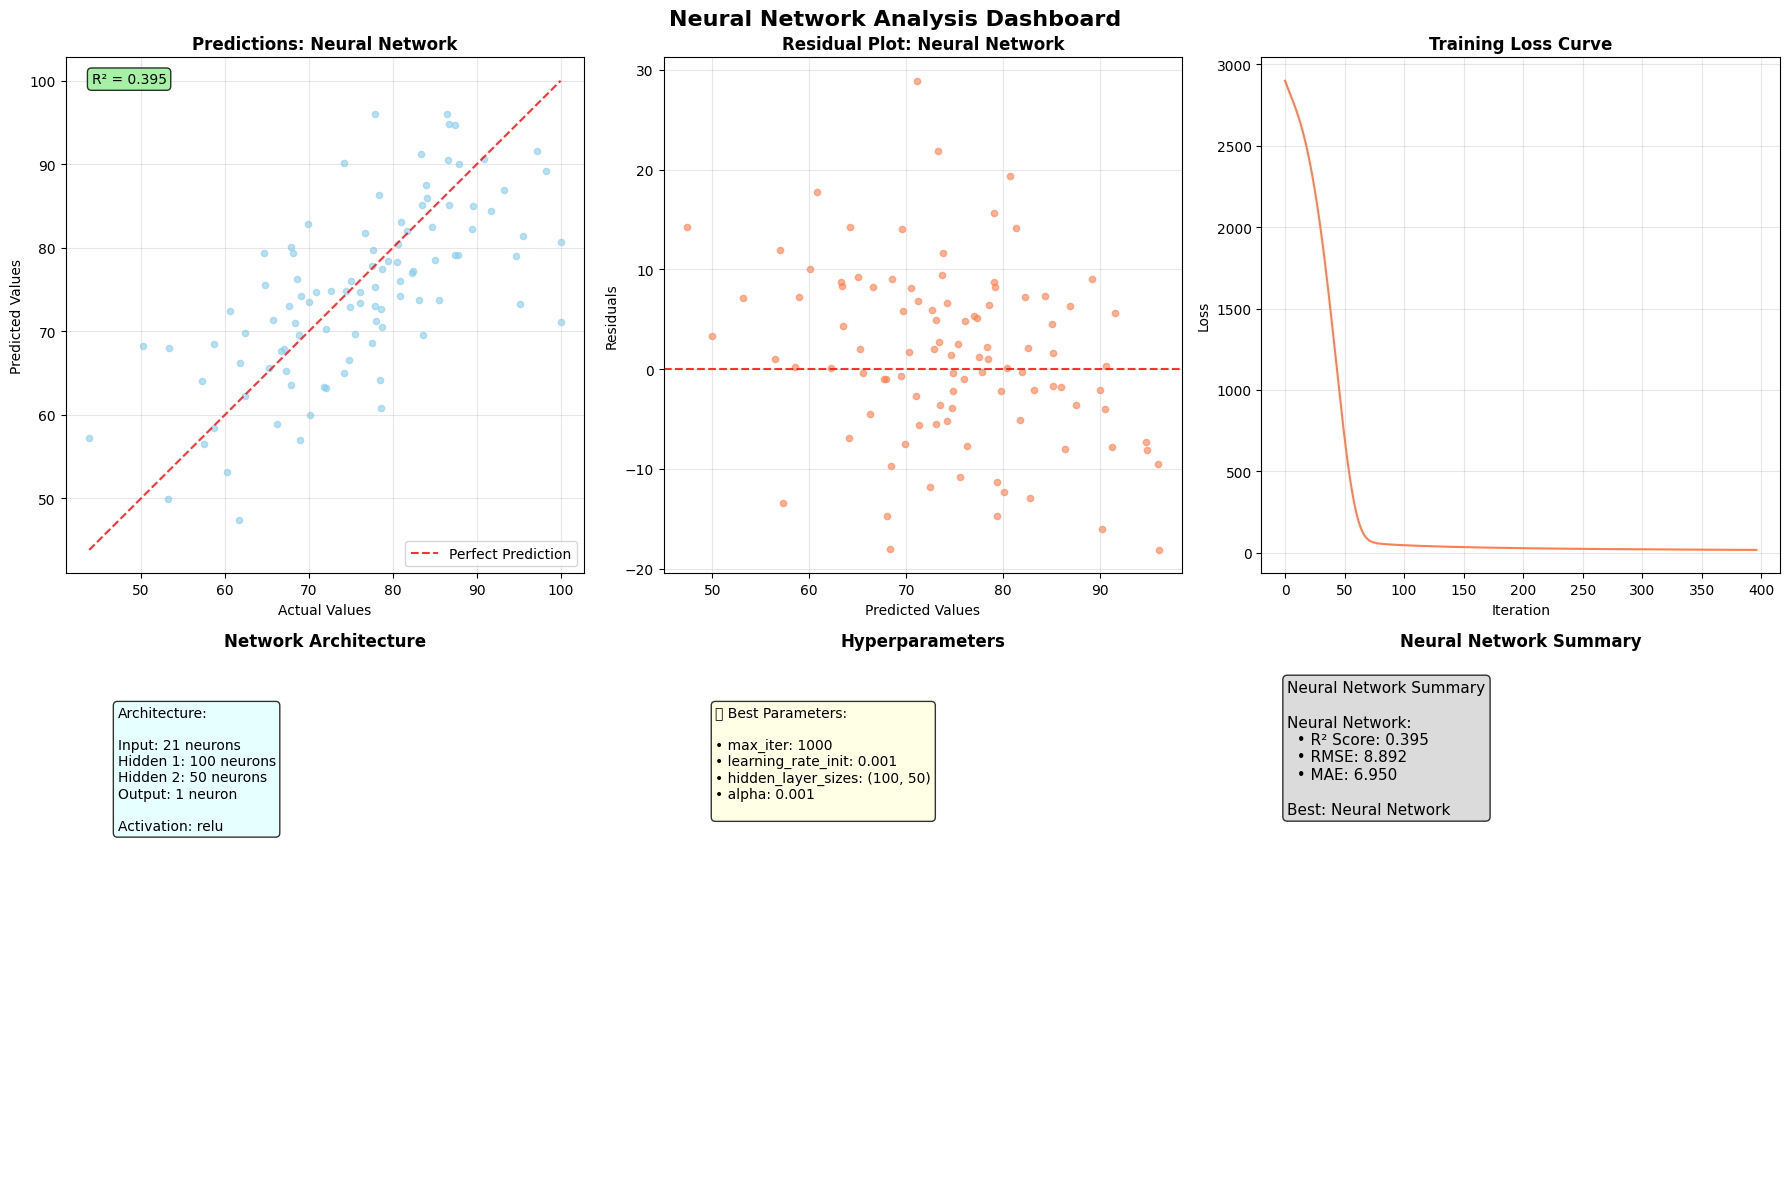

In [ ]:
def train_neural_network_regression(X, y, test_size=0.2, cv_folds=5, n_iter=15, visualize=True):
    """
    Train Neural Network regression model with architecture search.
    """
    print("TRAINING NEURAL NETWORK REGRESSION MODEL")
    print("-" * 50)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_SEED)
    print(f"Data split: {X_train.shape[0]} train, {X_test.shape[0]} test samples")

    # Scale features (critical for neural networks!)
    print(f"Scaling features for neural network...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print(f"   Features scaled (mean=0, std=1)")

    # Define architecture search space
    param_grid = {
        'hidden_layer_sizes': [
            (50,), (100,), (150,),  # Single layer
            (50, 25), (100, 50), (150, 75),  # Two layers
            (100, 50, 25)  # Three layers
        ],
        'learning_rate_init': [0.001, 0.01, 0.1],
        'alpha': [0.0001, 0.001, 0.01],  # L2 regularization
        'max_iter': [500, 1000]
    }

    print(f"Architecture search: {len(param_grid['hidden_layer_sizes'])} architectures")
    print(f"Search iterations: {n_iter}")

    # Show example architectures
    print(f"\nEXAMPLE ARCHITECTURES:")
    for i, arch in enumerate(param_grid['hidden_layer_sizes'][:3]):
        layers_str = f"{X.shape[1]} → " + " → ".join(map(str, arch)) + " → 1"
        print(f"   {i+1}. {layers_str}")

    start_time = time.time()

    # Create neural network with early stopping
    nn_model = MLPRegressor(
        random_state=RANDOM_SEED,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20
    )

    # Architecture search
    print(f"\nStarting neural architecture search...")
    random_search = RandomizedSearchCV(
        nn_model, param_grid, n_iter=n_iter, cv=cv_folds,
        scoring='r2', random_state=RANDOM_SEED, n_jobs=-1
    )
    random_search.fit(X_train_scaled, y_train)
    training_time = time.time() - start_time

    # Get best model
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)

    # Calculate metrics
    metrics = {
        'r2': r2_score(y_test, y_pred),
        'mse': mean_squared_error(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred)
    }

    cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=cv_folds, scoring='r2')
    training_history = getattr(best_model, 'loss_curve_', None)

    # Store results
    results = {
        'model': best_model,
        'scaler': scaler,
        'metrics': metrics,
        'cv_scores': cv_scores,
        'training_time': training_time,
        'best_params': random_search.best_params_,
        'best_cv_score': random_search.best_score_,
        'training_history': training_history,
        'y_pred': y_pred,
        'y_test': y_test
    }

    # Print results
    print(f"\nNEURAL NETWORK TRAINING COMPLETED!")
    print(f"   R² Score: {metrics['r2']:.3f}")
    print(f"   RMSE: {np.sqrt(metrics['mse']):.3f}")
    print(f"   CV Score: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
    print(f"   Training time: {training_time:.2f}s")

    # Architecture details
    print(f"\nOPTIMAL ARCHITECTURE:")
    best_arch = random_search.best_params_['hidden_layer_sizes']
    layers_str = f"{X.shape[1]} → " + " → ".join(map(str, best_arch)) + " → 1"
    print(f"   {layers_str}")

    print(f"\nBEST HYPERPARAMETERS:")
    for param, value in random_search.best_params_.items():
        print(f"   • {param}: {value}")

    # Training insights
    if training_history is not None:
        print(f"\nTRAINING INSIGHTS:")
        print(f"   • Training iterations: {len(training_history)}")
        print(f"   • Final loss: {training_history[-1]:.4f}")
        print(f"   • Early stopping: {'Yes' if len(training_history) < random_search.best_params_['max_iter'] else 'No'}")

    if visualize:
        create_neural_network_dashboard(results, X_test_scaled, y_test)

    return results



nn_results = train_neural_network_regression(X, y, n_iter=10, visualize=True)

---
## Step 11: Complete Model Comparison

Comprehensive head-to-head comparison of all trained models.

**Key Concepts:**
- **Model Performance**: R², RMSE, MAE across all models
- **Cross-validation**: Robust performance estimation
- **Model Selection**: Choosing the best model for deployment


In [ ]:
def model_training_pipeline_demo(X, y, create_visualizations=True):
    """
    Demonstrates the complete model training pipeline step by step.
    Students can run this to see the full model selection process.

    Args:
        X: Feature matrix
        y: Target variable
        create_visualizations: Whether to create dashboard visualizations

    Returns:
        dict: Complete results from all training steps
    """
    print("=" * 80)
    print("COMPLETE MODEL TRAINING PIPELINE DEMONSTRATION")
    print("=" * 80)

    pipeline_results = {}

    # Step 1: Data Validation
    print("\n" + "="*60)
    print("STEP 1: DATA VALIDATION & PREPARATION")
    print("="*60)

    print(f"Dataset Overview:")
    print(f"   • Samples: {X.shape[0]:,}")
    print(f"   • Features: {X.shape[1]:,}")
    print(f"   • Target range: {y.min():.3f} to {y.max():.3f}")
    print(f"   • Target mean: {y.mean():.3f} (±{y.std():.3f})")

    # Check for missing values
    missing_features = X.isnull().sum().sum() if hasattr(X, 'isnull') else 0
    missing_target = y.isnull().sum() if hasattr(y, 'isnull') else 0

    print(f"\nData Quality Check:")
    print(f"   • Missing values in features: {missing_features}")
    print(f"   • Missing values in target: {missing_target}")

    if missing_features == 0 and missing_target == 0:
        print(f"   Data quality: EXCELLENT - No missing values")
    else:
        print(f"   Data quality: CAUTION - Missing values detected")

    pipeline_results['data_validation'] = {
        'n_samples': X.shape[0],
        'n_features': X.shape[1],
        'target_stats': {'mean': y.mean(), 'std': y.std(), 'min': y.min(), 'max': y.max()},
        'missing_features': missing_features,
        'missing_target': missing_target
    }

    # Step 2: Linear Regression Baseline
    print("\n" + "="*60)
    print("STEP 2: LINEAR REGRESSION BASELINE")
    print("="*60)
    linear_results = train_linear_regression(X, y, visualize=create_visualizations)
    pipeline_results['linear_models'] = linear_results

    # Step 3: Tree-based Model Training
    print("\n" + "="*60)
    print("STEP 3: TREE-BASED MODEL TRAINING")
    print("="*60)
    xgb_results = train_xgboost_regression(X, y, n_iter=15, visualize=create_visualizations)
    pipeline_results['tree_model'] = xgb_results

    # Step 4: Neural Network Training
    print("\n" + "="*60)
    print("STEP 4: NEURAL NETWORK TRAINING")
    print("="*60)
    nn_results = train_neural_network_regression(X, y, n_iter=10, visualize=create_visualizations)
    pipeline_results['neural_network'] = nn_results

    # Step 5: Cross-validation Analysis
    print("\n" + "="*60)
    print("STEP 5: CROSS-VALIDATION ANALYSIS")
    print("="*60)
    cv_results = cross_validate_models(X, y, visualize=create_visualizations)
    pipeline_results['cross_validation'] = cv_results

    # Step 6: Final Model Selection
    print("\n" + "="*60)
    print("STEP 6: FINAL MODEL SELECTION")
    print("="*60)

    # Compile all models for comparison
    all_models = {}

    # Best linear model
    best_linear_name = max(linear_results.keys(), key=lambda x: linear_results[x]['metrics']['r2'])
    all_models[f'Linear ({best_linear_name})'] = linear_results[best_linear_name]

    # Tree-based model
    model_name = 'XGBoost' if XGBOOST_AVAILABLE else 'RandomForest'
    all_models[model_name] = xgb_results

    # Neural network
    all_models['Neural Network'] = nn_results

    # Final selection based on multiple criteria
    print(f"FINAL MODEL SELECTION ANALYSIS:")
    print(f"\nPerformance Summary:")

    selection_criteria = {}
    for model_name, results in all_models.items():
        r2_score = results['metrics']['r2']
        cv_mean = np.mean(results['cv_scores'])
        cv_std = np.std(results['cv_scores'])
        training_time = results.get('training_time', 0)

        # Composite score: performance + consistency + efficiency
        performance_score = (r2_score + cv_mean) / 2  # Average test and CV performance
        consistency_score = 1 - cv_std  # Reward low variance
        efficiency_score = 1 / (training_time + 1)  # Reward fast training

        composite_score = (performance_score * 0.7 + consistency_score * 0.2 + efficiency_score * 0.1)

        selection_criteria[model_name] = {
            'r2_score': r2_score,
            'cv_mean': cv_mean,
            'cv_std': cv_std,
            'training_time': training_time,
            'composite_score': composite_score
        }

        print(f"   {model_name}:")
        print(f"      • Test R²: {r2_score:.3f}")
        print(f"      • CV Mean: {cv_mean:.3f} (±{cv_std:.3f})")
        print(f"      • Training Time: {training_time:.2f}s")
        print(f"      • Composite Score: {composite_score:.3f}")

    # Select final model
    final_model_name = max(selection_criteria.keys(), key=lambda x: selection_criteria[x]['composite_score'])
    final_model_results = all_models[final_model_name]

    print(f"\nSELECTED MODEL: {final_model_name}")
    print(f"   Final R² Score: {final_model_results['metrics']['r2']:.3f}")
    print(f"   CV Performance: {np.mean(final_model_results['cv_scores']):.3f} (±{np.std(final_model_results['cv_scores']):.3f})")
    print(f"   Training Time: {final_model_results.get('training_time', 0):.2f}s")

    # Model-specific insights
    print(f"\nMODEL INSIGHTS:")
    if final_model_name.startswith('Linear'):
        print(f"   • Linear relationship dominates the data")
        print(f"   • Model is highly interpretable and fast")
        print(f"   • Good choice for production deployment")
    elif 'XGBoost' in final_model_name or 'RandomForest' in final_model_name:
        print(f"   • Complex non-linear patterns in the data")
        print(f"   • Feature importance available for interpretability")
        print(f"   • Robust to different data types and missing values")
    else:
        print(f"   • Very complex patterns requiring neural networks")
        print(f"   • High model capacity for complex relationships")
        print(f"   • May require more data and careful tuning")

    pipeline_results['final_selection'] = {
        'selected_model': final_model_name,
        'model_results': final_model_results,
        'selection_criteria': selection_criteria
    }

    # Step 7: Production Readiness Assessment
    print("\n" + "="*60)
    print("STEP 7: PRODUCTION READINESS ASSESSMENT")
    print("="*60)

    final_r2 = final_model_results['metrics']['r2']
    cv_std = np.std(final_model_results['cv_scores'])

    print(f"PRODUCTION READINESS CHECKLIST:")

    # Performance check
    if final_r2 > 0.8:
        print(f"   Performance: EXCELLENT (R² > 0.8)")
        performance_status = "EXCELLENT"
    elif final_r2 > 0.6:
        print(f"   Performance: GOOD (R² > 0.6)")
        performance_status = "GOOD"
    elif final_r2 > 0.4:
        print(f"   Performance: ACCEPTABLE (R² > 0.4)")
        performance_status = "ACCEPTABLE"
    else:
        print(f"   Performance: POOR (R² < 0.4)")
        performance_status = "POOR"

    # Stability check
    if cv_std < 0.05:
        print(f"   Stability: EXCELLENT (CV std < 0.05)")
        stability_status = "EXCELLENT"
    elif cv_std < 0.1:
        print(f"   Stability: GOOD (CV std < 0.1)")
        stability_status = "GOOD"
    else:
        print(f"   Stability: CONCERNING (High CV variance)")
        stability_status = "CONCERNING"

    # Overall recommendation
    if performance_status in ["EXCELLENT", "GOOD"] and stability_status in ["EXCELLENT", "GOOD"]:
        deployment_recommendation = "READY FOR PRODUCTION"
        print(f"\nDEPLOYMENT RECOMMENDATION: {deployment_recommendation}")
        print(f"   • Model performance and stability are suitable for production")
        print(f"   • Proceed with deployment planning and monitoring setup")
    elif performance_status == "ACCEPTABLE":
        deployment_recommendation = "DEPLOY WITH MONITORING"
        print(f"\nDEPLOYMENT RECOMMENDATION: {deployment_recommendation}")
        print(f"   • Model performance is acceptable but requires close monitoring")
        print(f"   • Consider collecting more data or feature engineering")
    else:
        deployment_recommendation = "NOT READY - REQUIRES IMPROVEMENT"
        print(f"\nDEPLOYMENT RECOMMENDATION: {deployment_recommendation}")
        print(f"   • Model performance is insufficient for production use")
        print(f"   • Collect more data, improve features, or try different approaches")

    pipeline_results['production_assessment'] = {
        'performance_status': performance_status,
        'stability_status': stability_status,
        'deployment_recommendation': deployment_recommendation
    }

    # Final Summary
    print("\n" + "="*80)
    print("MODEL TRAINING PIPELINE COMPLETED!")
    print("="*80)

    create_pipeline_summary(pipeline_results)

    return pipeline_results


def cross_validate_models(X, y, cv_folds=5, visualize=True):
    """
    Perform detailed cross-validation analysis on all model families.
    """
    print("CROSS-VALIDATION ANALYSIS")
    print("-" * 50)

    # Define models for cross-validation
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0)
    }

    # Add tree-based model
    if XGBOOST_AVAILABLE:
        models['XGBoost'] = xgb.XGBRegressor(random_state=42, n_jobs=-1, n_estimators=100)
    else:
        models['RandomForest'] = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=100)

    # Add neural network (with scaling)
    models['Neural Network'] = MLPRegressor(
        hidden_layer_sizes=(100, 50), random_state=42, max_iter=500
    )

    cv_results = {}
    scaler = StandardScaler()  # For neural network
    X_scaled = scaler.fit_transform(X)

    # Perform cross-validation for each model
    for name, model in models.items():
        print(f"Cross-validating {name}...")

        # Use scaled data for neural network, original for others
        X_to_use = X_scaled if 'Neural' in name else X

        # Perform cross-validation
        scores = cross_val_score(model, X_to_use, y, cv=cv_folds, scoring='r2')

        cv_results[name] = {
            'scores': scores,
            'mean': np.mean(scores),
            'std': np.std(scores),
            'min': np.min(scores),
            'max': np.max(scores)
        }

        print(f"  {name}: {np.mean(scores):.3f} (±{np.std(scores):.3f})")

    # Print detailed results
    print(f"\nCROSS-VALIDATION SUMMARY:")
    print("-" * 50)
    for name, results in cv_results.items():
        print(f"{name}:")
        print(f"  • Mean R²: {results['mean']:.3f}")
        print(f"  • Std Dev: {results['std']:.3f}")
        print(f"  • Range: {results['min']:.3f} - {results['max']:.3f}")
        print()

    if visualize:
        # Create cross-validation visualization
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle('Cross-Validation Analysis', fontsize=16, fontweight='bold')

        # 1. CV scores boxplot
        create_cv_scores_boxplot(
            {model: cv_results[model]['scores'] for model in cv_results.keys()},
            list(cv_results.keys()), axes[0]
        )

        # 2. Mean scores comparison
        mean_scores = {model: cv_results[model]['mean'] for model in cv_results.keys()}
        create_performance_comparison_chart(
            {model: {'metrics': {'r2': mean_scores[model]}} for model in mean_scores.keys()},
            'r2', 'Cross-Validation Mean R² Scores', axes[1]
        )

        save_and_show_plot('cross_validation_analysis.png')

    print(f"Cross-validation analysis completed!")
    return cv_results


def create_pipeline_summary(pipeline_results):
    """
    Create a comprehensive summary of the model training pipeline.
    """
    print(f"\nMODEL TRAINING PIPELINE SUMMARY")
    print("-" * 60)

    # Data summary
    data_info = pipeline_results['data_validation']
    print(f"DATASET SUMMARY:")
    print(f"   • Samples: {data_info['n_samples']:,}")
    print(f"   • Features: {data_info['n_features']:,}")
    print(f"   • Target Range: {data_info['target_stats']['min']:.3f} to {data_info['target_stats']['max']:.3f}")
    print(f"   • Data Quality: {'EXCELLENT' if data_info['missing_features'] == 0 else 'NEEDS ATTENTION'}")

    # Model performance summary
    final_selection = pipeline_results['final_selection']
    selected_model = final_selection['selected_model']
    model_results = final_selection['model_results']

    print(f"\nSELECTED MODEL: {selected_model}")
    print(f"   • R² Score: {model_results['metrics']['r2']:.3f}")
    print(f"   • RMSE: {np.sqrt(model_results['metrics']['mse']):.3f}")
    print(f"   • MAE: {model_results['metrics']['mae']:.3f}")
    print(f"   • CV Performance: {np.mean(model_results['cv_scores']):.3f} (±{np.std(model_results['cv_scores']):.3f})")

    # Production readiness
    prod_assessment = pipeline_results['production_assessment']
    print(f"\nPRODUCTION READINESS: {prod_assessment['deployment_recommendation']}")
    print(f"   • Performance Status: {prod_assessment['performance_status']}")
    print(f"   • Stability Status: {prod_assessment['stability_status']}")

    # Key learnings
    print(f"\n🎓 KEY LEARNINGS:")
    print(f"   • Model Selection: Systematic comparison of multiple approaches")
    print(f"   • Cross-validation: Essential for robust performance estimation")
    print(f"   • Hyperparameter Tuning: Can significantly improve performance")
    print(f"   • Production Considerations: Performance + Stability + Interpretability")

    print(f"\nPipeline completed successfully!")
    print(f"   The model is ready for the next phase of development!")


# Example usage:

pipeline_results = model_training_pipeline_demo(X, y, create_visualizations=True)

print("\n" + "="*80)
print("MODULE 3 COMPLETE!")
print("You have learned:")
print("   • Linear Regression Models (Linear, Ridge, Lasso)")
print("   • Tree-based Models (XGBoost/RandomForest)")
print("   • Neural Networks (Multi-layer Perceptron)")
print("   • Hyperparameter Optimization (Grid vs Random Search)")
print("   • Model Comparison and Selection")
print("   • Cross-validation and Production Readiness")
print("\nCongratulations! You now have production-level ML skills!")
print("="*80)

COMPLETE MODEL TRAINING PIPELINE DEMONSTRATION

STEP 1: DATA VALIDATION & PREPARATION
Dataset Overview:
   • Samples: 500
   • Features: 21
   • Target range: 37.675 to 100.000
   • Target mean: 74.781 (±12.271)

Data Quality Check:
   • Missing values in features: 0
   • Missing values in target: 0
   Data quality: EXCELLENT - No missing values

STEP 2: LINEAR REGRESSION BASELINE
TRAINING LINEAR REGRESSION MODELS
--------------------------------------------------
Data split: 400 train, 100 test samples

Training Linear Regression...
R² = 0.583, RMSE = 7.385
CV Score: 0.542 (±0.061)

Training Ridge Regression...
R² = 0.582, RMSE = 7.385
CV Score: 0.542 (±0.060)

Training Lasso Regression...
R² = 0.394, RMSE = 8.898
CV Score: 0.377 (±0.047)

BEST: Linear Regression (R² = 0.583)
Lasso zeroed out 15 features (feature selection)
